<br> <img src="https://serea2017.uniandes.edu.co/images/Logo.png" height="80" width="150" align="Center" /> <br>
    
<br>
<center> <h2>Maestría en Inteligencia Analítica para la Toma de Decisiones</h2> </center>
<br>

##### Presentado por:

    Arturo Guerrero            (201823464)
    Carlos Andres Paez Rojas   (201924257)     

<h4> Octubre 2020 </h4>
<br>

## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II
# Micro-Proyecto 1

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

A continuación escriba los nombres de los integrantes del grupo.

Nombres: 
Arturo Guerrero           (201823464)
Carlos Andres Paez Rojas  (201924257)


### Introducción
Una *start-up* agrícola quiere construir una aplicación online que conecte el campo
con la ciudad de manera directa y sin intermediarios. De esta manera, los agricultores ponen a la disposición de la empresa sus distintos productos, y la start-up se encarga de atender las necesidades de demanda distribuyendo los productos hasta los clientes finales en la ciudad.

Para optimizar la gestión logística y desarrollar esta labor de manera eficiente, los dueños de la *start-up* han visto la necesidad de diseñar e implementar un sistema de gestión y predicción que les permita planear con la debida anticipación la demanda esperada. Así podrán coordinar las actividades de producción, junto con los agricultores, y atender la demanda mientras se minimizan las pérdidas por unidades de producto no vendido o estropeado. 

Este es un reto altamente relevante para la sostenibilidad de la industria alimentaria, donde gran cantidad de las pérdidas se refieren a grupos alimenticios donde la frescura del producto es un importante criterio para el consumo. El desperdicio de los alimentos se relaciona con el sobre-pedido o el sobre-almacenamiento, lo cual puede a su vez ser consecuencia de dificultades en el pronóstico de la demanda. Este problema es aun más marcado a medida que uno sube en la cadena de producción y se aleja de los patrones de comportamiento del consumidor final. 

Por lo tanto, la start-up agrícola debe gestionar los inventarios de manera inteligente, disminuyendo la ventana de tiempo entre cosecha y consumo. Para ello, necesita desarrollar modelos de predicción de demanda que apoyen su operación, logrando la disponibilidad de los productos para atender a los clientes del día siguiente, minimizando los desperdicios de alimentos e identificando hábitos de consumo que le permita optimizar sus operaciones logísticas y de negocio.

### Enunciado
Por ello se le pide a usted, en calidad de consultor externo, desarrollar un modelo predictivo de demanda para los productos más relevantes con los que trabaja la start-up agrícola, obteniendo una predicción a nivel semanal (una semana adelante). Los datos los encuentra en el archivo DatosAgro.txt, donde se tiene la identificación del cliente, la fecha en que realizó el pedido, la magnitud del pedido (en unidades según lo especificado en el nombre del producto), su precio, y el código del producto agrícola que consta en el pedido.

## 1. Visualicemos los datos

In [4]:
import pandas as pd
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

In [5]:
# Importemos los datos y visualizemos la serie de tiempo
data = pd.read_csv("C:/Users/Carlos P/Modelos Av 2/Datasets/DatosAgro.txt", delimiter='\t', encoding="utf8")
data = data.drop('Unnamed: 6', 1)
data.head()

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto
0,Cliente26,18/09/2017,20,700,VER0049,Yerbabuena / 100 gramos
1,Cliente26,18/09/2017,10,1200,FRU0024,Limón Tahití / Libra
2,Cliente26,18/09/2017,4,1600,VER0041,Puerro / Libra
3,Cliente26,18/09/2017,10,1500,VER0038,Pimentón Rojo / Libra
4,Cliente26,18/09/2017,8,1100,VER0010,Zucchini Verde / Libra


Veamos los clientes con mayor participación en la demanda:

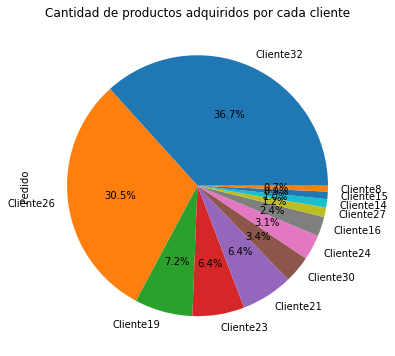

In [6]:
cliente = pd.DataFrame(data[data['Pedido'] > 10].groupby(data["Cliente"]).sum())
cliente2 = cliente[cliente['Pedido']>50]
cliente3 = cliente2.sort_values("Pedido", ascending= False)
cliente3.plot.pie(y='Pedido', figsize=(6, 6), legend=False, autopct='%1.1f%%')
plt.title("Cantidad de productos adquiridos por cada cliente")
plt.show()


Vemaos los productos con más volumen de pedido:

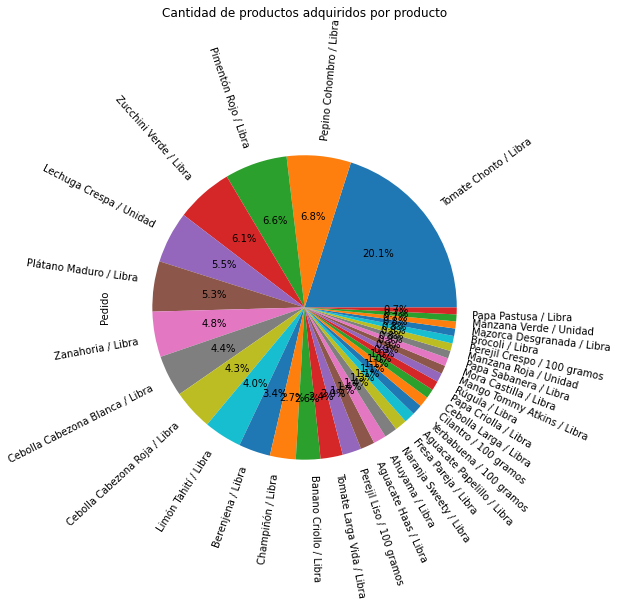

In [7]:
productos = pd.DataFrame(data["Pedido"].groupby(data["Nombre_producto"]).sum())
productos2 = productos[productos['Pedido']>140]
productos3 = productos2.sort_values("Pedido", ascending= False)
productos3.plot.pie(y='Pedido', figsize=(7, 7), legend=False, autopct='%1.1f%%', rotatelabels=True)
plt.title("Cantidad de productos adquiridos por producto", pad=100)
plt.show()

A continuación implemente la metodología propuesta para construir su modelo:

### Realizamos importación de librerías requeridas:

In [8]:
import datetime as dt
import seaborn as sb

from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from fbprophet import Prophet

from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Análisis y exploración de datos:

In [9]:
data.shape

(4712, 6)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4712 entries, 0 to 4711
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Cliente          4708 non-null   object
 1   Fecha            4712 non-null   object
 2   Pedido           4712 non-null   int64 
 3   Precio           4712 non-null   int64 
 4   Producto         4712 non-null   object
 5   Nombre_producto  4712 non-null   object
dtypes: int64(2), object(4)
memory usage: 221.0+ KB


In [11]:
data["Fecha"] = pd.to_datetime(data["Fecha"])  
data = data.sort_values(["Fecha", "Cliente"], ascending= True)
data.dtypes

Cliente                    object
Fecha              datetime64[ns]
Pedido                      int64
Precio                      int64
Producto                   object
Nombre_producto            object
dtype: object

In [12]:
data.describe(include='all')

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto
count,4708,4712,4712.000000,4712.000000,4712,4712
unique,33,242,NaN,NaN,121,121
top,Cliente32,2017-07-02 00:00:00,NaN,NaN,FRU0046,Tomate Chonto / Libra
freq,932,97,NaN,NaN,355,355
first,NaN,2016-01-12 00:00:00,NaN,NaN,NaN,NaN
last,NaN,2017-12-09 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,4.914474,2065.488115,NaN,NaN
std,NaN,NaN,7.493867,1823.445580,NaN,NaN
min,NaN,NaN,1.000000,200.000000,NaN,NaN
25%,NaN,NaN,1.000000,1100.000000,NaN,NaN


### Identificación de valores faltantes

#### Se identifican 4 registros sin identificación del cliente, los cuales corresponde a una descripción única de los clientes, se decide excluir dichos registros ya que no existe método de imputación para los mismos.

In [13]:
data = data.dropna()

In [14]:
data.describe(include='all')

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto
count,4708,4708,4708.000000,4708.000000,4708,4708
unique,33,242,NaN,NaN,121,121
top,Cliente32,2017-07-02 00:00:00,NaN,NaN,FRU0046,Tomate Chonto / Libra
freq,932,97,NaN,NaN,354,354
first,NaN,2016-01-12 00:00:00,NaN,NaN,NaN,NaN
last,NaN,2017-12-09 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,4.905055,2065.989805,NaN,NaN
std,NaN,NaN,7.479063,1824.073544,NaN,NaN
min,NaN,NaN,1.000000,200.000000,NaN,NaN
25%,NaN,NaN,1.000000,1100.000000,NaN,NaN


### Análisis Descriptivo

#### Inicialmente podemos observar la cantidad de pedidos y precio asociado, de todos los clientes para todos los productos, agrupado por semana:

In [15]:
data['year'] = data['Fecha'].dt.year
data['year_m'] = (data['Fecha'].dt.year * 100) + (data['Fecha'].dt.month)
data['year_w'] = (data['Fecha'].dt.year * 100) + (data['Fecha'].dt.week)

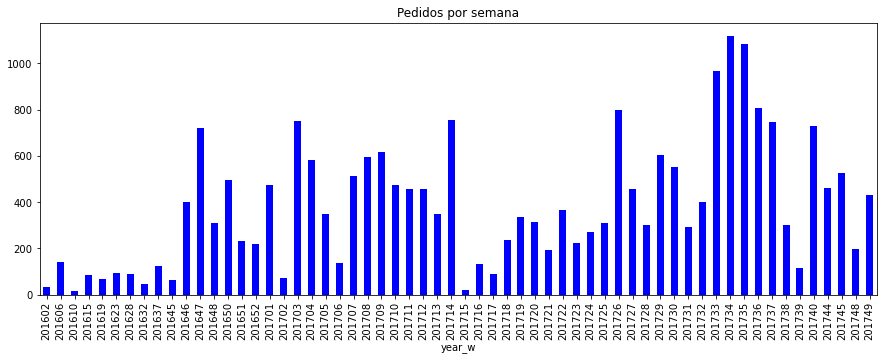

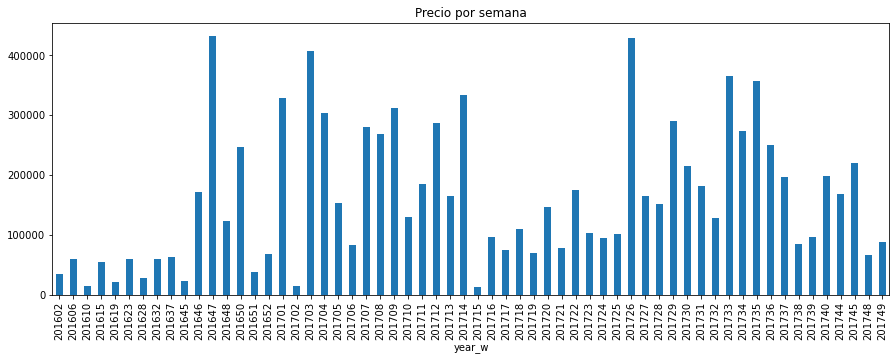

In [16]:
gr = data[["year_w", "Pedido"]].groupby(["year_w"]).sum().plot(kind="bar", legend=False, color='blue', figsize=(15,5), fontsize=10)
plt.title("Pedidos por semana")
gr = data[["year_w", "Precio"]].groupby(["year_w"]).sum().plot(kind="bar", legend=False, figsize=(15,5), fontsize=10)
plt.title("Precio por semana")
plt.show()

#### Podemos evidenciar en la gráfica anterior:
> No existen pedidos de productos para todas las semanas de los dos años (2016 y 2017), principalmente para el **2026**

> Bajo nivel de pedidos para los primeros meses de **2016**

> **2017** con niveles de pedidos consistentes, aunque se aprecian ciertas semanas con valores atípicos, muy bajos y elevados al nivel promedio

> No se identifica una tendencia clara, tampoco se podría intuir estacionalidad

#### Por consiguiente, teniendo en cuenta los análisis anteriores, se decide incluir dentro de los datos la totalidad de semanas de los dos años con valores en 0. Esto con el supuesto de tener 0 solicitudes de productos por cliente en dichas semanas y asumir una estrategia conservadora para evitar una predicción elevada de productos para las siguientes semanas.

In [17]:
data_o = pd.read_csv("C:/Users/Carlos P/Modelos Av 2/Datasets/DatosAgro_otro.csv", delimiter=',', encoding="utf8")
data_o["Fecha"] = pd.to_datetime(data_o["Fecha"])  
data_o.head()

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto
0,Cliente1,2016-01-12,0,0,NaN,NaN
1,Cliente1,2016-01-13,0,0,NaN,NaN
2,Cliente1,2016-01-14,0,0,NaN,NaN
3,Cliente1,2016-01-15,0,0,NaN,NaN
4,Cliente1,2016-01-16,0,0,NaN,NaN


#### Consolidamos los registros y damos formato adecuado.

In [18]:
data_t = data.append(data_o)
data_t["Fecha"] = pd.to_datetime(data_t["Fecha"])  
data_t.head()

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto,year,year_m,year_w
4343,Cliente7,2016-01-12,2,500,TUB0012,Zanahoria / Libra,2016.0,201601.0,201602.0
4344,Cliente7,2016-01-12,3,1100,FRU0046,Tomate Chonto / Libra,2016.0,201601.0,201602.0
4345,Cliente7,2016-01-12,1,1600,TUB0009,Rábano Rojo / Libra,2016.0,201601.0,201602.0
4346,Cliente7,2016-01-12,1,1600,VER0041,Puerro / Libra,2016.0,201601.0,201602.0
4347,Cliente7,2016-01-12,1,630,VER0035,Pepino Cohombro / Libra,2016.0,201601.0,201602.0


In [19]:
data = data.sort_values(['Fecha', 'Cliente'], ascending= True)
data_t = data_t.sort_values(['Fecha', 'Cliente'], ascending= True)

#### Graficamos el total de pedidos y precio asociado por día.
#### Se observan con mayor claridad los periodos sin solicitudes por parte de los clientes.

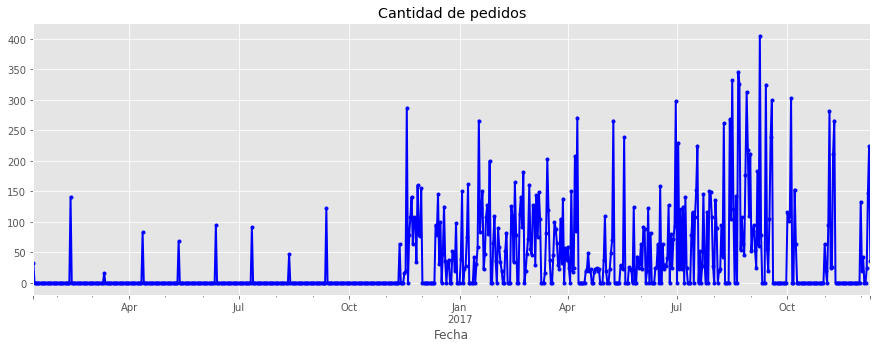

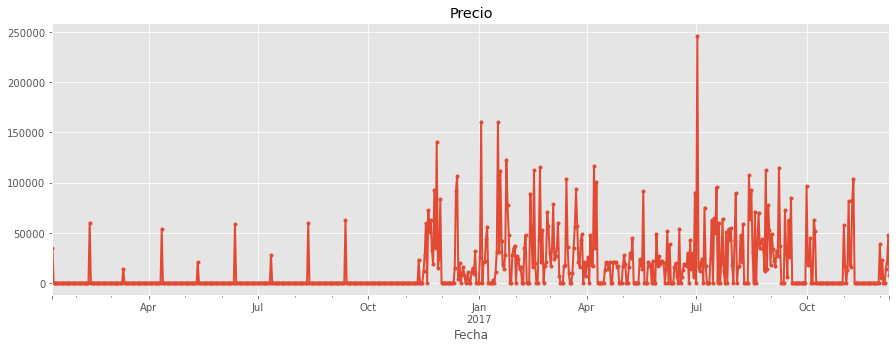

In [20]:
plt.style.use('ggplot')
gr = data_t[["Fecha", "Pedido"]].groupby(["Fecha"]).sum().plot(style='.-', legend=False, color='blue', figsize=(15,5), linewidth=2, fontsize=10)
plt.title("Cantidad de pedidos")
gr = data_t[["Fecha", "Precio"]].groupby(["Fecha"]).sum().plot(style='.-', legend=False, figsize=(15,5), linewidth=2, fontsize=10)
plt.title("Precio")
plt.show()

In [21]:
data_o['year'] = data_o['Fecha'].dt.year
data_o['year_m'] = (data_o['Fecha'].dt.year * 100) + (data_o['Fecha'].dt.month)
data_o['year_w'] = (data_o['Fecha'].dt.year * 100) + (data_o['Fecha'].dt.week)
data_t['year'] = data_t['Fecha'].dt.year
data_t['year_m'] = (data_t['Fecha'].dt.year * 100) + (data_t['Fecha'].dt.month)
data_t['year_w'] = (data_t['Fecha'].dt.year * 100) + (data_t['Fecha'].dt.week)

#### Obtenemos algunos descriptivos totales de los datos

In [22]:
c1 = data_t[["year_m", "Pedido"]].groupby(["year_m"]).describe()
c1.head(24)

Pedido                                                
         count      mean       std  min  25%  50%   75%    max
year_m                                                        
201601   682.0  0.048387  0.290332  0.0  0.0  0.0  0.00    3.0
201602   992.0  0.142137  0.956658  0.0  0.0  0.0  0.00   14.0
201603  1027.0  0.015579  0.332969  0.0  0.0  0.0  0.00   10.0
201604  1019.0  0.081452  0.796751  0.0  0.0  0.0  0.00   17.0
201605  1038.0  0.065511  0.659874  0.0  0.0  0.0  0.00   11.0
201606  1017.0  0.092429  0.937680  0.0  0.0  0.0  0.00   22.0
201607  1042.0  0.087332  0.885931  0.0  0.0  0.0  0.00   20.0
201608  1048.0  0.044847  0.356268  0.0  0.0  0.0  0.00    6.0
201609  1025.0  0.119024  0.847491  0.0  0.0  0.0  0.00   14.0
201610  1023.0  0.000000  0.000000  0.0  0.0  0.0  0.00    0.0
201611  1350.0  1.108889  4.901778  0.0  0.0  0.0  1.00  111.0
201612  1216.0  0.779605  2.785757  0.0  0.0  0.0  0.00   34.0
201701  1546.0  1.309832  3.244970  0.0  0.0  0.0  1.00   50.0
201702  1286.0  1.304821  3.297034  0.0  0.0  0.0  1.00   36.0
201703  1429.0  1.423373  3.725796  0.0  0.0  0.0  1.00   44.0
201704  1221.0  0.883702  3.173596  0.0  0.0  0.0  0.00   50.0
201705  1264.0  0.933544  3.548155  0.0  0.0  0.0  0.00   50.0
201706  1290.0  1.271318  3.917203  0.0  0.0  0.0  0.00   50.0
201707  1535.0  1.413681  4.302171  0.0  0.0  0.0  1.00  100.0
201708  1643.0  2.194766  6.946186  0.0  0.0  0.0  2.00  100.0
201709  1320.0  1.577273  5.613001  0.0  0.0  0.0  0.25  100.0
201710  1156.0  0.730969  4.624547  0.0  0.0  0.0  0.00  126.0
201711  1190.0  0.831092  2.950538  0.0  0.0  0.0  0.00   40.0
201712   383.0  1.631854  6.601422  0.0  0.0  0.0  0.00   80.0

#### Graficamos el total de pedidos y precio agrupado de manera mensual.

#### Claramente se aprecia bajos niveles de pedidos para los primeros **10** meses (2016)

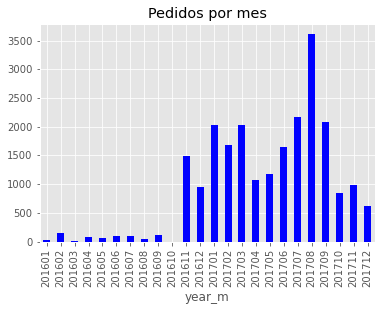

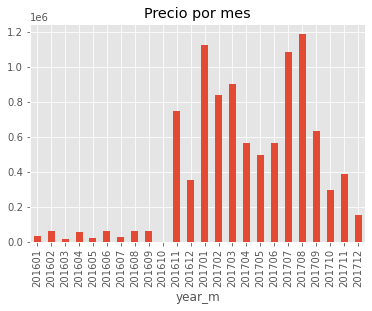

In [23]:
gr = data_t[["year_m", "Pedido"]].groupby(["year_m"]).sum().plot(kind="bar", legend=False, color='blue')
plt.title("Pedidos por mes")
gr = data_t[["year_m", "Precio"]].groupby(["year_m"]).sum().plot(kind="bar", legend=False)
plt.title("Precio por mes")
plt.show()

### Creación de funciones: 

#### A continuación se declara la totalidad de métodos usados para el desarrollo de los modelos:  

#### Función de análisis por medio de boxplot  

In [24]:
def g_boxplot(data):
    c2 =  data
    sb.boxplot(x=c2["year_m"], y=c2["Pedido"]);
    return

#### Función de aplicación método “Isolation Forest” para detección de outliers.

In [25]:
def iforest(data):
    iso = IsolationForest(contamination=0.1)
    data['yhat'] = iso.fit_predict(data[['year_w','Pedido']])
    print(data[['yhat', 'Cliente']].groupby(['yhat']).count())
    return data

#### Test D.Fuller para identificación de estacionariedad en la serie de datos. 

In [26]:
def t_fuller(data):
    result = adfuller(data['Pedido'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return

#### Funciones de análisis de tendencia, estacionalidad y funciones de autocorrelación y autocorrelación parcial. 

In [27]:
def ts_obs(data):
    data[['Pedido']].plot(figsize=(15,5), linewidth=2, fontsize=10, color=('b', 'r'), legend = False)
    plt.xlabel('Weeks');
    plt.suptitle('Pedidos por semana')
    plt.show();    
    return

def ts_tendencia(data):
    data[['Pedido']].rolling(8).mean().plot(figsize=(15,5), linewidth=2, fontsize=10, color=('b', 'r'), legend = False)
    plt.xlabel('Weeks');
    plt.suptitle('Tendencia de pedidos semanal')
    plt.show();
    return

def ts_estacionalidad(data):
    data[['Pedido']].diff().plot(figsize=(15,5), linewidth=2, fontsize=10, color=('b', 'r'), legend = False)
    plt.xlabel('Weeks');
    plt.suptitle('Estacionalidad')
    plt.show(); 
    return

def acf_pacf(data):
    plot_acf(data['Pedido']);
    plot_pacf(data['Pedido']);
    return

#### ARIMA

In [28]:
def arima(data):
    X = data['Pedido']
    size = int(len(X) * 0.9)
    train, test = X[0:size], X[size:len(X)]
    test = [x for x in test]
    mse = list()
    for ar in range(1, 11): 
        train_x = [x for x in train]
        predictions = list()
        for t in range(len(test)):
            model = ARIMA(train_x, order=(ar, 0, 0))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            train_x.append(test[t])
        error = mean_squared_error(test, predictions) 
        mse.append(error)
    min_mse = min(mse)
    ar_num = mse.index(min_mse)
    ar_num = ar_num + 1
    mse = pd.DataFrame(mse)
    mse.plot(legend = False, color = 'green')
    plt.suptitle('MSE', fontsize=10)
    plt.show();
    return ar_num

def arima1(data, ar_num):
    X = data['Pedido']
    size = int(len(X) * 0.9)
    train, test = X[0:size], X[size:len(X)]
    test = [x for x in test]
    train_x = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(train_x, order=(ar_num, 0, 0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        train_x.append(test[t])
    plt.plot(test, color='blue')
    plt.plot(predictions, color='red')
    plt.suptitle('Obs Vs Pred', fontsize=10)
    plt.show();
    error = mean_squared_error(test, predictions) 
    print('Test MSE: %.3f' % error)
    mse_ar = error
    
    print(model_fit.summary())
    
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot(legend = False)
    plt.suptitle('residuals', fontsize=10);

    residuals.plot(kind='kde', legend = False)
    plt.suptitle('residuals', fontsize=10);
    print(residuals.describe())

    return mse_ar, predictions

def arima2(data, ar_num):
    X = data['Pedido']
    train, test = X, X[len(X)-1:len(X)]
    train_x = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(train_x, order=(ar_num, 0, 0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
    return predictions

### Prophet

In [29]:
def prophet(data):
    X = data[['ds','y']]
    #X = data['y']
    size = int(len(X) * 0.9)
    #train = data.head(int(len(df)*(0.9)))
    #test = data.tail(int(len(df)*(0.1)))
    train, test = X[0:size], X[size:len(X)]
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    train_x = train
    predictions_p = list()
    m = Prophet()
    m.fit(train_x)
    for t in range(0, len(test)):
        future = test[['ds']].iloc[[t],[0]]
        forecast = m.predict(future)
        df_fcast = forecast[['ds', 'yhat']]
        lista = df_fcast.iloc[[0],[1]].values.tolist()
        lista = str(lista).strip('[]')
        lista = int(float(lista[0:7]))
        predictions_p.append(lista)
        train_x = train_x.append(test.iloc[[t],[0,1]])
        m = Prophet()
        m.fit(train_x)
        
    #test = X[len(X) - test.shape[0]:len(X)]
    test = X['y'][len(X) - test.shape[0]:len(X)]
    test = [x for x in test]
    
    error = mean_squared_error(test, predictions_p) 
    print('Test MSE: %.3f' % error)
    mse_pro = error
    return mse_pro, test, predictions_p

def prophet2(data):
    X = data[['ds','y']]
    train, test = X, X[len(X)-1:len(X)]
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    train_x = train
    predictions_p = list()
    m = Prophet()
    m.fit(train_x)
    for t in range(0, len(test)):
        future = test[['ds']].iloc[[t],[0]]
        forecast = m.predict(future)
        df_fcast = forecast[['ds', 'yhat']]
        lista = df_fcast.iloc[[0],[1]].values.tolist()
        lista = str(lista).strip('[]')
        lista = int(float(lista[0:7]))
        predictions_p.append(lista)
    return predictions_p

### Alistamiento y selección de datos para diferente escenario 

In [30]:
def datos(data):
    data1 = data[['Fecha', 'Pedido', 'Precio', 'Producto', 'Nombre_producto', 'year_w']]

    data2 = data1[["year_w", "Fecha"]].groupby(["year_w"]).min()
    data2.rename(columns={"Fecha":"Fecha_min"}, inplace=True)

    data3 = pd.DataFrame(pd.merge(left=data1, right=data2, how='inner', on='year_w'))
    data3 = data3[['Fecha_min', 'year_w', 'Pedido', 'Precio']].groupby(['Fecha_min', 'year_w']).sum().reset_index()
    data3['ticket'] = data3['Precio'] / data3['Pedido']
    new_data = data3
    return new_data

In [31]:
def datos_prophet(data):
    df_n = pd.DataFrame()
    df_n['ds'] = pd.to_datetime(data['Fecha_min'])
    df_n['y'] = data['Pedido']
    return df_n

### **Proceso principal** – Ejecución secuencial de todas las funciones definidas y generación de graficas para análisis de resultados y conclusiones   

In [32]:
def proceso(data_n, new_data):
    g_boxplot(data_n)
    t_fuller(new_data)
    ts_obs(new_data)
    ts_tendencia(new_data)
    ts_estacionalidad(new_data)
    acf_pacf(new_data)

    ar_num_n = arima(new_data)
    print(ar_num_n)
    mse_ar_n, predictions_n = arima1(new_data, ar_num_n)

    df_n = pd.DataFrame()
    df_n['ds'] = pd.to_datetime(new_data['Fecha_min'])
    df_n['y'] = new_data['Pedido']
    mse_pro_n, test_n, predictions_p_n = prophet(df_n)

    test_n = pd.DataFrame(test_n)
    predictions_n = pd.DataFrame(predictions_n)
    predictions_p_n = pd.DataFrame(predictions_p_n)
    test_n = test_n.rename(columns={0: 'Obs'})
    predictions_n = predictions_n.rename(columns={0: 'Arima'})
    predictions_p_n = predictions_p_n.rename(columns={0: 'Prophet'})
    grafica_n = pd.concat([test_n, predictions_n, predictions_p_n], axis=1)
    grafica_n[['Obs', 'Arima', 'Prophet']].plot(color=('b', 'r', 'g'))
    plt.suptitle('Resultados', fontsize=10)
    plt.show();

    print(mse_ar_n, mse_pro_n)
    return ar_num_n, mse_ar_n, mse_pro_n

In [33]:
def grafica_final(i):
    gr_pru = data_n[(data_n.Nombre_producto == productos4.index[i])]
    gr_pru = gr_pru[["year_w", "Pedido"]].groupby(["year_w"]).sum()
    pre_arima = {'Pedido': [predictions_ari[i]]}
    pre_arima = pd.DataFrame (pre_arima, columns = ['Pedido'])
    pre_arima.values.tolist()
    val = pre_arima.values.tolist()
    val = str(val).strip('[]')
    val = int(float(val[7:11]))
    pre_arima = {'Pedido': [val]}
    pre_arima = pd.DataFrame (pre_arima, columns = ['Pedido'])
    pre_pro = pd.DataFrame(predictions_pro[i])
    pre_pro = pre_pro.rename(columns={0: 'Pedido'})
    gr_pru_1 = gr_pru.append(pre_arima)
    gr_pru_1 = gr_pru_1.rename(index={0: 'Arima'})
    gr_pru_2 = gr_pru_1.append(pre_pro)
    gr_pru_2 = gr_pru_2.rename(index={0: 'Prophet'})
    gr = gr_pru_2.plot(kind="bar", legend=False, color='blue', figsize=(15,5), fontsize=10)
    plt.title(productos4.index[i])
    plt.show();

### Identificación de valores atípicos: 

### **2016**

#### Como se evidenció anteriormente, existen niveles de pedidos muy diferentes para cada año. Asi, visualizamos boxplot por mes por año. 

#### Para Noviembre de 2016 se intuye la presencia de valores atípicos.

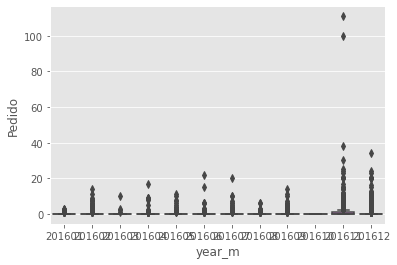

In [34]:
g_boxplot(data_t[(data_t.year == 2016)])

### **2017**

#### Para los niveles de pedidos en el año 2017 se intuye la presencia de valores atípicos por encima de 60 u 80 unidades, principalmente para los meses de Julio a Octubre.

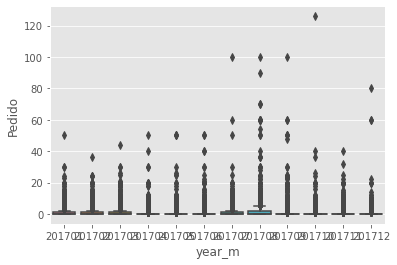

In [35]:
g_boxplot(data_t[(data_t.year == 2017)])

#### Ejecutamos el método **IsolationForest** de **sklearn**. Algoritmo de detección de valores atípicos basado en árboles.

In [36]:
data = iforest(data)

      Cliente
yhat         
-1        469
 1       4239


#### Se etiquetan **469** valores como atípicos para la totalidad de la serie de datos, a continuación vemos en un boxplot la cantidad de pedidos por mes excluyendo dichos valores:     

#### Graficamos nuevamente boxplot para valores no atípicos.

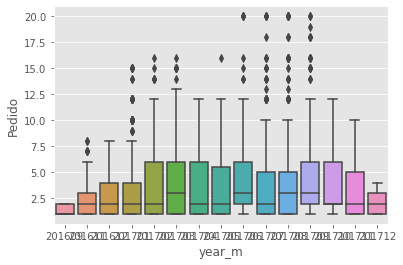

In [37]:
g_boxplot(data[(data.yhat == 1)])

#### Es claro que desde la perspectiva de demanda de productos para consumo diario existen diferentes variables que influyen en fluctuaciones de hábitos de consumo, ya que estos factores no son evidentes en este momento, para nuestros siguientes análisis y actividades excluiremos los valores atípicos identificados asumiendo una estrategia conservadora en la estimación fututa de demanda.

#### Por consiguiente, graficamos nuevamente la cantidad de pedidos y precio asociado, de todos los clientes para todos los productos, agrupado por semana:

#### Después del tratamiento de valores atípicos, podemos observar a continuación básicamente que los datos se centran en el 2017, en todo caso no se excluyen las semanas correspondientes a 2016. 

In [38]:
data = data[(data.yhat == 1)]
del data['yhat']
data.describe(include='all')

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto,year,year_m,year_w
count,4239,4239,4239.000000,4239.000000,4239,4239,4239.000000,4239.000000,4239.000000
unique,31,233,NaN,NaN,118,118,NaN,NaN,NaN
top,Cliente29,2017-07-02 00:00:00,NaN,NaN,FRU0046,Tomate Chonto / Libra,NaN,NaN,NaN
freq,856,97,NaN,NaN,265,265,NaN,NaN,NaN
first,NaN,2016-09-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2017-12-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,3.696155,2121.174805,NaN,NaN,2016.883699,201694.636471,201713.665723
std,NaN,NaN,3.331980,1881.275557,NaN,NaN,0.320623,30.404411,27.007215
min,NaN,NaN,1.000000,200.000000,NaN,NaN,2016.000000,201609.000000,201637.000000
25%,NaN,NaN,1.000000,1100.000000,NaN,NaN,2017.000000,201702.000000,201706.000000


In [39]:
data_bk = data
data_t = data_bk.append(data_o)
data = data_t

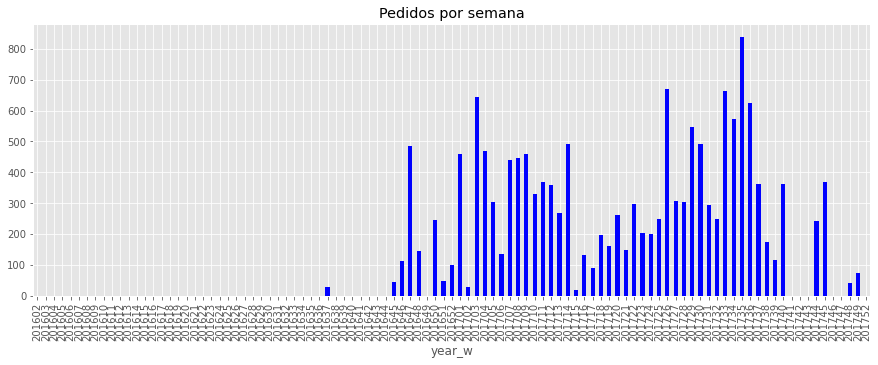

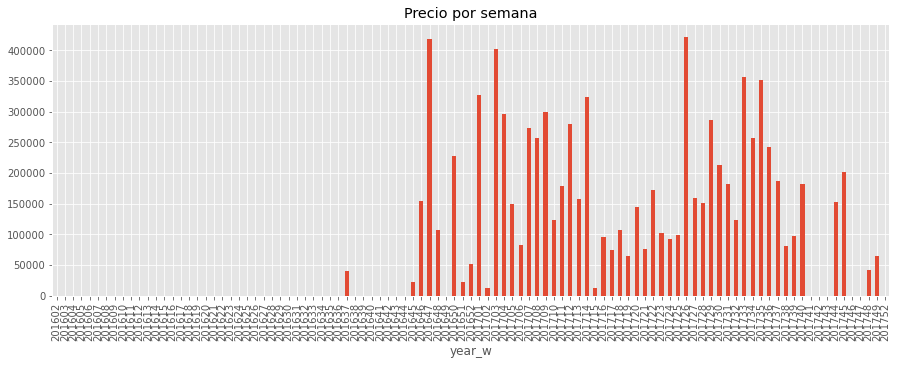

In [40]:
gr = data[["year_w", "Pedido"]].groupby(["year_w"]).sum().plot(kind="bar", legend=False, color='blue', figsize=(15,5), fontsize=10)
plt.title("Pedidos por semana")
gr = data[["year_w", "Precio"]].groupby(["year_w"]).sum().plot(kind="bar", legend=False, figsize=(15,5), fontsize=10)
plt.title("Precio por semana")
plt.show()

### Construcción del modelo de predicción de la serie de tiempo. 

#### Aplicamos el test de D.Fuller para evaluar estacionariedad en la serie de datos. 

#### Una serie de tiempo es estacionaria si su media y varianza, permanecen constantes en el tiempo. Es una característica requerida para la construcción de modelos de series de tiempo.

In [41]:
t_fuller(data)

ADF Statistic: -4.843301
p-value: 0.000045
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


#### Con P-value de 0, se rechaza la hipótesis nula, así se concluye que contamos con evidencia estadística para decir que la serie de datos es estacionaria.

#### Inicialmente realizamos una predicción de pedidos utilizando un modelo ARIMA, entrenaremos nuestro modelo con el **90%** de las semanas y estimaremos el **10%** aplicando un ciclo de Rolling forecast. 

#### En nuestro proceso de Rolling forecast se estima la primera semana y se incluye lo observado de dicha semana en nuestra base de entrenamiento para la estimación de la segunda semana, se itera de la misma manera hasta obtener la predicción total del 10% de las semanas a estimar.


#### Alistamiento del dataset insumo:

In [42]:
data1 = data[['Fecha', 'Pedido', 'Precio', 'Producto', 'Nombre_producto', 'year_w']]

In [43]:
data2 = data1[["year_w", "Fecha"]].groupby(["year_w"]).min()
data2.rename(columns={"Fecha":"Fecha_min"}, inplace=True)

In [44]:
data3 = pd.DataFrame(pd.merge(left=data1, right=data2, how='inner', on='year_w'))
data3 = data3[['Fecha_min', 'year_w', 'Pedido', 'Precio']].groupby(['Fecha_min', 'year_w']).sum().reset_index()
data3['ticket'] = data3['Precio'] / data3['Pedido']
data3.head()

,Fecha_min,year_w,Pedido,Precio,ticket
0,2016-01-12,201602,0,0,NaN
1,2016-01-18,201603,0,0,NaN
2,2016-01-25,201604,0,0,NaN
3,2016-02-01,201605,0,0,NaN
4,2016-02-08,201606,0,0,NaN


In [45]:
data3.shape

(101, 5)

#### Visualizamos los valores observados por semana:

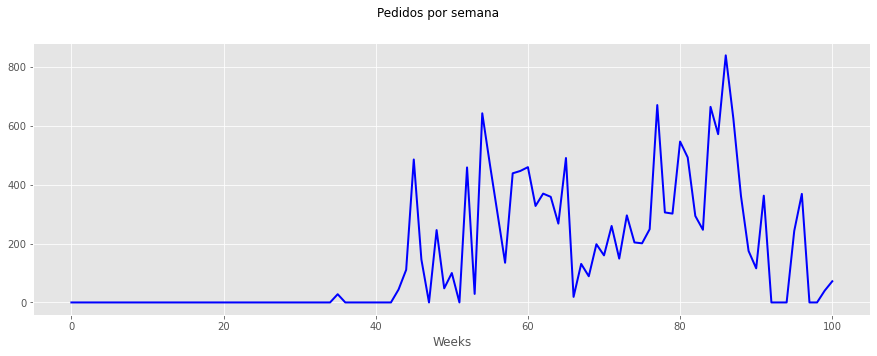

In [46]:
ts_obs(data3)

#### Visualizamos la tendencia de pedidos totales:

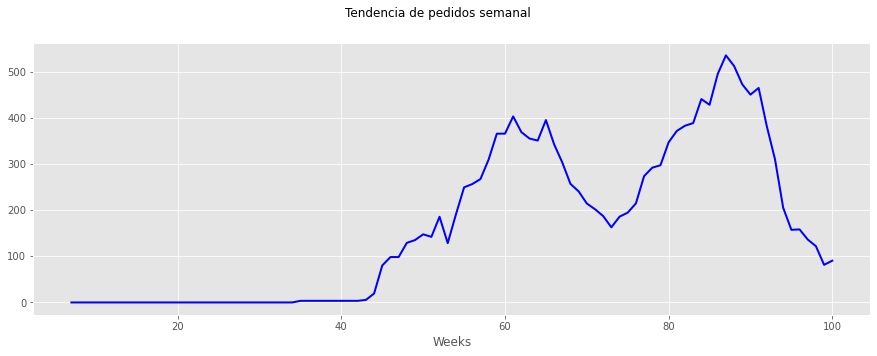

In [47]:
ts_tendencia(data3)

#### Como se observa anteriormente, se puede evidenciar una tendencia creciente durante aproximadamente 3 meses, luego una decreciente en los siguientes 3 meses. Se repite para los siguientes 6 meses. La grafica esta construida con un Rolling de 8 semanas que equivale a 2 meses aproximadamente.  

#### Visualizamos posible estacionalidad de pedidos totales:

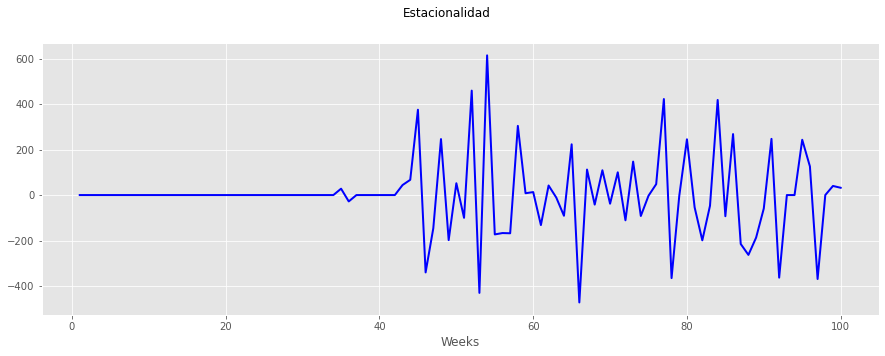

In [48]:
ts_estacionalidad(data3)

#### Con respecto a la gráfica anterior, no podemos intuir alguna estacionalidad marcada en la serie,  se evidencian 3 picos inferiores pero con distinta periodicidad.  

#### A continuación, calibraremos un modelo Arima y posteriormente un modelo utilizando el algoritmo Prophet. Evaluaremos el desempeño de los modelos utilizando la métrica **MSE**. 

#### Debido al alto número de productos a predecir, inicialmente la predicción se realizará para la totalidad de productos sin identificación del tipo de producto ni el cliente, esto con el objetivo de tener lecturas totales y a partir de los resultados tomar decisiones que prioricen futuras predicciones por producto. 

### ARIMA

#### A continuación generamos las gráficas acf y pacf para evidenciar correlación, identificar si observaciones pasadas influyen en las observaciones actuales.

#### Con la función ACF queremos identificar el proceso de media móvil (MA) y con la función PACF identificar el proceso autorregresivo (AR), para la construcción de un modelo ARIMA.

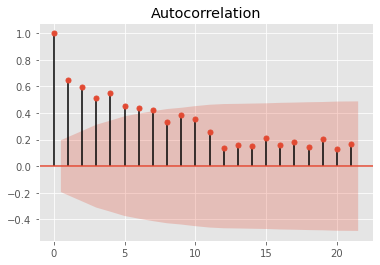

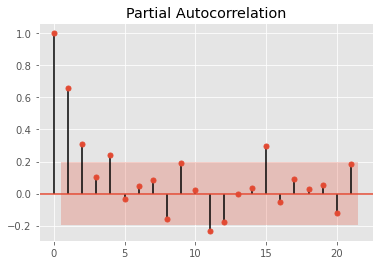

In [49]:
acf_pacf(data3)

#### Inicialmente construimos un modelo ARIMA iterando en el proceso autorregresivo de 1 a 10. Posteriormente, evaluamos la métrica de desempeño **MSE**. 

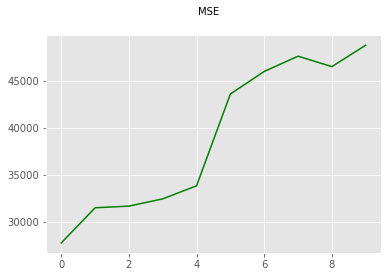

In [50]:
ar_num = arima(data3)

In [51]:
ar_num

1

#### Como se observa en la gráfica anterior, el mejor desempeño (menor MSE) corresponde a **1** en el parámetro **AR**

#### Graficamos los valores predichos versus los observados para las ultimas semanas de la serie de tiempo, que corresponden al 10%:

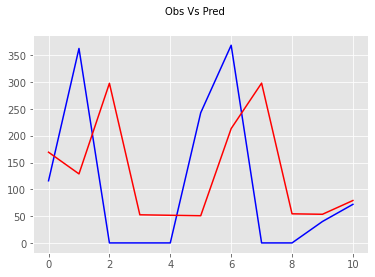

Test MSE: 27745.486
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  100
Model:                     ARMA(1, 0)   Log Likelihood                -647.616
Method:                       css-mle   S.D. of innovations            156.727
Date:                Tue, 13 Oct 2020   AIC                           1301.233
Time:                        12:17:44   BIC                           1309.048
Sample:                             0   HQIC                          1304.396
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        151.1392     43.720      3.457      0.001      65.449     236.829
ar.L1.y        0.6477      0.075      8.600      0.000       0.500       0.795
                                

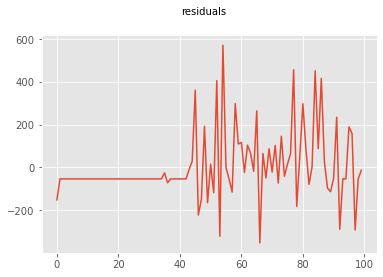

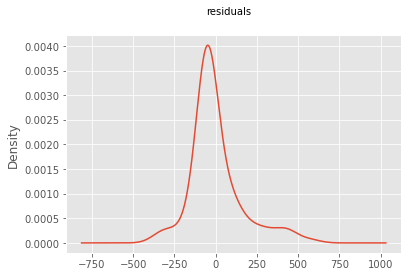

In [52]:
mse_ar, predictions = arima1(data3, ar_num)

#### La media de los residuales se encuentra en 0.97, lo que representa algo de sesgo en los datos. 

#### A continuación ejecutamos la predicción utilizando el algoritmo Prophet:

### Prophet

In [53]:
df = pd.DataFrame()
df['ds'] = pd.to_datetime(data3['Fecha_min'])
df['y'] = data3['Pedido']

In [54]:
mse_pro, test, predictions_p = prophet(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Test MSE: 105828.091


In [55]:
test = pd.DataFrame(test)
predictions = pd.DataFrame(predictions)
predictions_p = pd.DataFrame(predictions_p)
test = test.rename(columns={0: 'Obs'})
predictions = predictions.rename(columns={0: 'Arima'})
predictions_p = predictions_p.rename(columns={0: 'Prophet'})
grafica = pd.concat([test, predictions, predictions_p], axis=1)

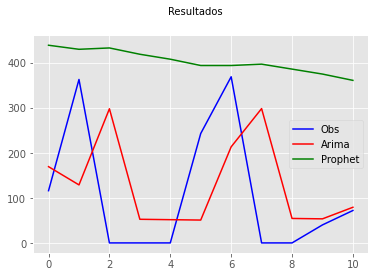

In [56]:
grafica[['Obs', 'Arima', 'Prophet']].plot(color=('b', 'r', 'g'))
plt.suptitle('Resultados', fontsize=10);

In [57]:
print('MSE Arima: ', mse_ar)
print('MSE Prophet: ', mse_pro)

MSE Arima:  27745.485736902363
MSE Prophet:  105828.09090909091


#### La gráfica anterior corresponde a los valores predichos con Arima y con Prophet, versus los valores observados: Así, se aprecia, la predicción de Arima más ajustada a recientes fluctuaciones en los datos, por el contrario, la predicción con Prophet para totas las observaciones se encuentran por encima de lo observado, lo cual correspondería a niveles mayores observados en periodos anteriores, se identifica una tendencia decreciente pero muy moderada. 

#### Teniendo en cuenta la métrica de desempeño **MSE**, se aprecia mejor desempeño utilizando un modelo Arima.

#### A continuación, buscamos una metodología para acotar los datos y realizar nuevas estimaciones.

#### Identificando los clientes con mayor participación en el volumen de pedidos histórico

In [58]:
clientes = pd.DataFrame(data['Pedido'].groupby(data["Cliente"]).sum())
clientes['total'] = data["Pedido"].sum()
clientes['participacion'] = clientes['Pedido'] / clientes['total']
clientes = clientes.sort_values(['participacion'], ascending = False)
clientes = clientes[(clientes.Pedido > 265)]
clientes['total_part'] = clientes['participacion'].sum()
clientes.head(30)

,Pedido,total,participacion,total_part
Cliente,,,,
Cliente32,3805,15668,0.242852,0.907901
Cliente29,3140,15668,0.200408,0.907901
Cliente21,2309,15668,0.147370,0.907901
Cliente3,1100,15668,0.070207,0.907901
Cliente19,876,15668,0.055910,0.907901
Cliente26,778,15668,0.049655,0.907901
Cliente13,462,15668,0.029487,0.907901
Cliente10,446,15668,0.028466,0.907901
Cliente16,393,15668,0.025083,0.907901


#### Identificamos **12** clientes de los **33** totales, realizan el **90.7%** de los pedidos. 

#### Acotando nuestra base de datos a los 12 clientes identificados con mayor participación para posteriormente priorizar la predicción de demanda por producto.

In [59]:
data1 = pd.merge(left=data, right=clientes, how='inner', on='Cliente')
data1.rename(columns={"Pedido_x":"Pedido"}, inplace=True)
data1.drop( ['Pedido_y', 'total', 'participacion', 'total_part'], axis=1, inplace=True )
data1.describe(include='all')

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto,year,year_m,year_w
count,12096,12096,12096.000000,12096.000000,3720,3720,12096.000000,12096.000000,12096.000000
unique,12,698,NaN,NaN,113,113,NaN,NaN,NaN
top,Cliente29,2017-07-02 00:00:00,NaN,NaN,FRU0046,Tomate Chonto / Libra,NaN,NaN,NaN
freq,1554,82,NaN,NaN,255,255,NaN,NaN,NaN
first,NaN,2016-01-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2017-12-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.176009,648.165509,NaN,NaN,2016.621445,201668.479828,201687.735202
std,NaN,NaN,2.583028,1409.284280,NaN,NaN,0.485047,48.090162,48.408269
min,NaN,NaN,0.000000,0.000000,NaN,NaN,2016.000000,201601.000000,201602.000000
25%,NaN,NaN,0.000000,0.000000,NaN,NaN,2016.000000,201609.000000,201638.000000


#### Como se observa en los descriptivos anteriores, los **12** clientes tienen una participación en **113** productos de los **121** totales.

#### Por lo tanto, a continuación identificaremos los productos con mayor número de pedidos para los 12 clientes identificados anteriormente. 

In [79]:
productos = pd.DataFrame(data1["Pedido"].groupby(data1["Nombre_producto"]).sum())
productos3 = productos.sort_values("Pedido", ascending= False)
productos4 = productos3
productos4['total'] = productos3["Pedido"].sum()

productos4['participacion'] = productos4['Pedido'] / productos4['total']
productos4 = productos4.sort_values(['participacion'], ascending = False)
productos4 = productos4[(productos4.Pedido > 500)]
productos4['total_part'] = productos4['participacion'].sum()
productos4.head(50)

,Pedido,total,participacion,total_part
Nombre_producto,,,,
Tomate Chonto / Libra,2139,14225,0.150369,0.53413
Lechuga Crespa / Unidad,1000,14225,0.070299,0.53413
Zucchini Verde / Libra,905,14225,0.063620,0.53413
Pimentón Rojo / Libra,737,14225,0.051810,0.53413
Pepino Cohombro / Libra,668,14225,0.046960,0.53413
Berenjena / Libra,566,14225,0.039789,0.53413
Cebolla Cabezona Roja / Libra,554,14225,0.038946,0.53413
Limón Tahití / Libra,517,14225,0.036344,0.53413
Champiñón / Libra,512,14225,0.035993,0.53413


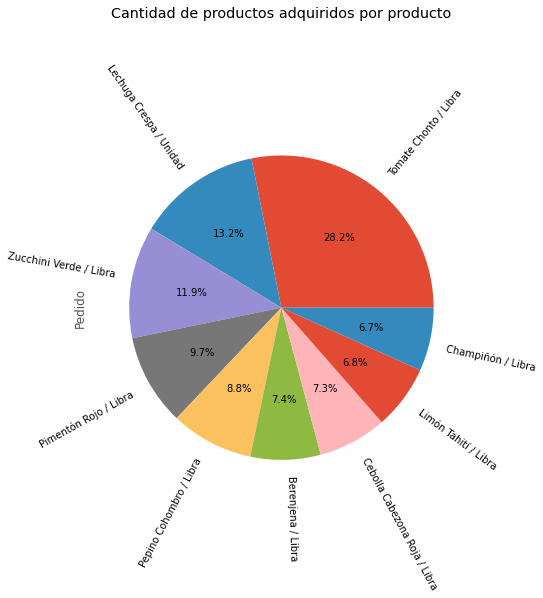

In [61]:
productos4.plot.pie(y='Pedido', figsize=(7, 7), legend=False, autopct='%1.1f%%', rotatelabels=True)
plt.title("Cantidad de productos adquiridos por producto", pad=100)
plt.show()

#### Identificamos **9** productos con mayor numero de pedidos en volumen, los cuales corresponden al **53.4%** del total de pedidos. 

In [62]:
data_n = pd.merge(left=data1, right=productos4, how='inner', on='Nombre_producto')
data_n.rename(columns={"Pedido_x":"Pedido"}, inplace=True)
data_n.drop( ['Pedido_y', 'total', 'participacion', 'total_part'], axis=1, inplace=True )
data_n.describe(include='all')

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto,year,year_m,year_w
count,1371,1371,1371.000000,1371.000000,1371,1371,1371.000000,1371.000000,1371.000000
unique,12,217,NaN,NaN,9,9,NaN,NaN,NaN
top,Cliente29,2017-08-28 00:00:00,NaN,NaN,FRU0046,Tomate Chonto / Libra,NaN,NaN,NaN
freq,488,22,NaN,NaN,255,255,NaN,NaN,NaN
first,NaN,2016-09-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2017-12-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,5.541940,2245.506929,NaN,NaN,2016.921955,201698.118891,201715.978848
std,NaN,NaN,3.693389,2106.355125,NaN,NaN,0.268341,25.416927,23.295975
min,NaN,NaN,1.000000,600.000000,NaN,NaN,2016.000000,201609.000000,201637.000000
25%,NaN,NaN,2.000000,1200.000000,NaN,NaN,2017.000000,201702.000000,201708.000000


#### A partir de estos datos calibramos nuevamente nuestros modelos **Arima** y **Prophet** teniendo en cuenta **12** clientes con el **90.7%** de pedidos y **8** productos con el **53.4%** de participación:

ADF Statistic: -3.961030
p-value: 0.001629
Critical Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


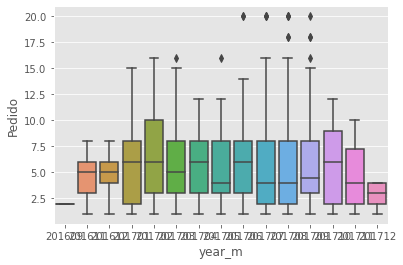

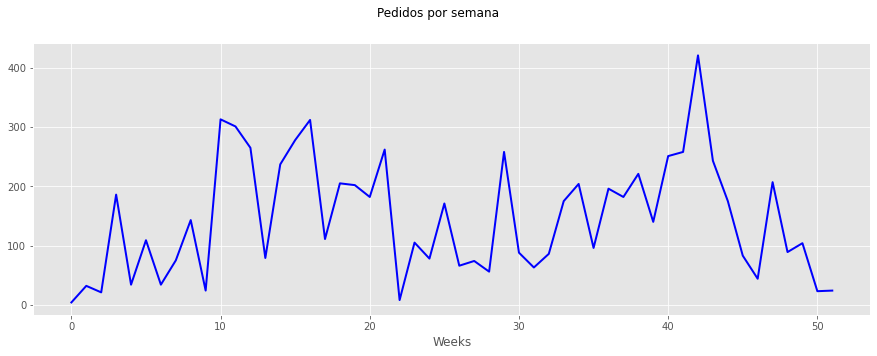

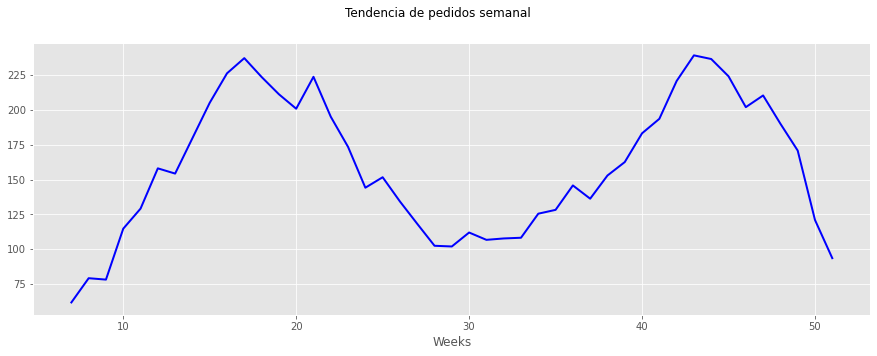

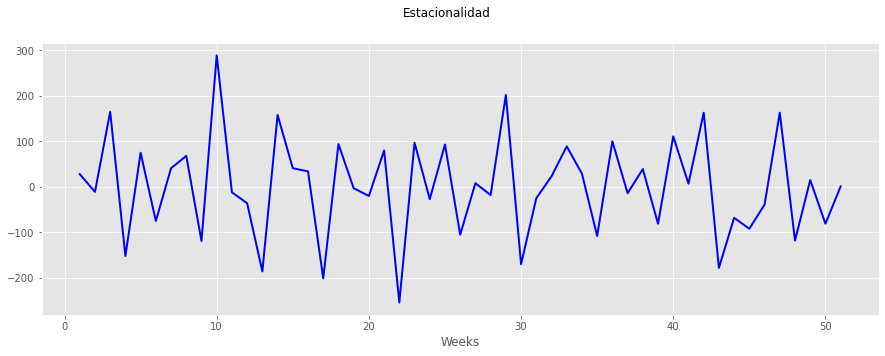

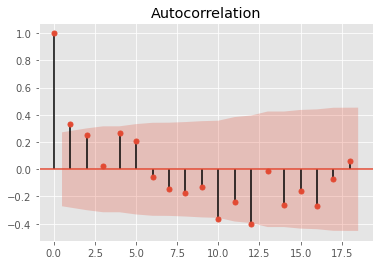

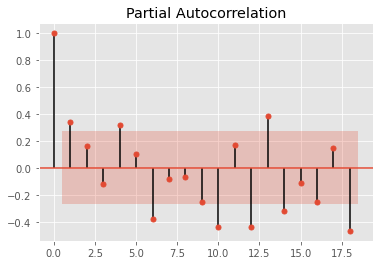

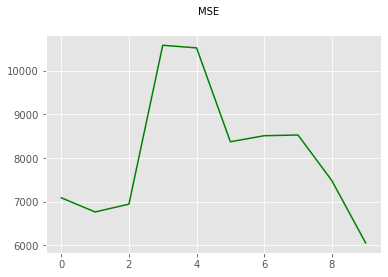

10


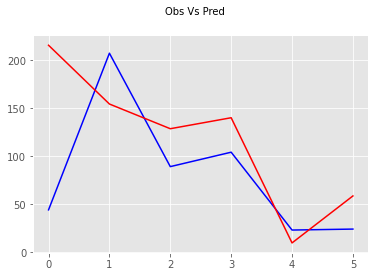

Test MSE: 6057.458


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   51
Model:                    ARMA(10, 0)   Log Likelihood                -290.566
Method:                       css-mle   S.D. of innovations             69.066
Date:                Tue, 13 Oct 2020   AIC                            605.131
Time:                        12:20:22   BIC                            628.313
Sample:                             0   HQIC                           613.990
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        154.1143      9.259     16.644      0.000     135.966     172.262
ar.L1.y        0.1921      0.124      1.546      0.122      -0.051       0.436
ar.L2.y        0.1990      0.127      1.567      0.1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Test MSE: 6190.833


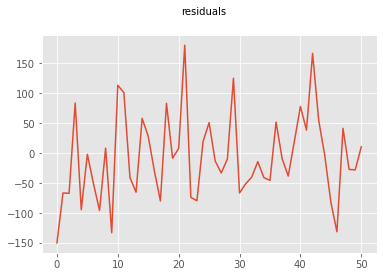

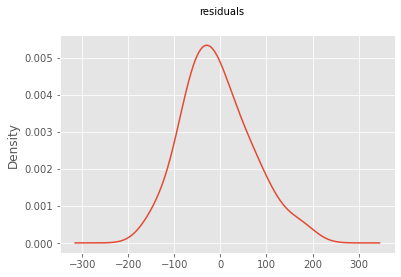

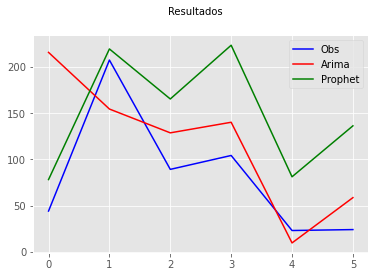

6057.457510429841 6190.833333333333


In [63]:
new_data = datos(data_n)
ar_num_n, mse_ar_n, mse_pro_n = proceso(data_n, new_data)

In [64]:
predictions_1 = arima2(data3, ar_num)
predictions_1

[array([99.78852963])]

In [65]:
predictions_2 = arima2(new_data, ar_num_n)
predictions_2

[array([12.13502221])]

In [66]:
df_n = datos_prophet(new_data)
predictions_2p = prophet2(df_n)
predictions_2p

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[106]

#### Finalmente, calibramos nuestros modelos **Arima** y **Prophet** para cada uno de los **9** productos priorizados, prediciendo el 10% de las semanas realizando el proceso de Rolling forecast. 

In [67]:
ar_num_proceso = list()
mse_ar_proceso = list()
mse_pro_proceso = list()

PRODUCTO #:  Tomate Chonto / Libra
ADF Statistic: -4.722585
p-value: 0.000076
Critical Values:
	1%: -3.589
	5%: -2.930
	10%: -2.603


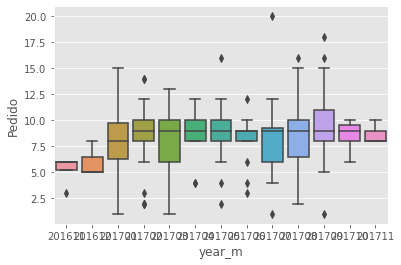

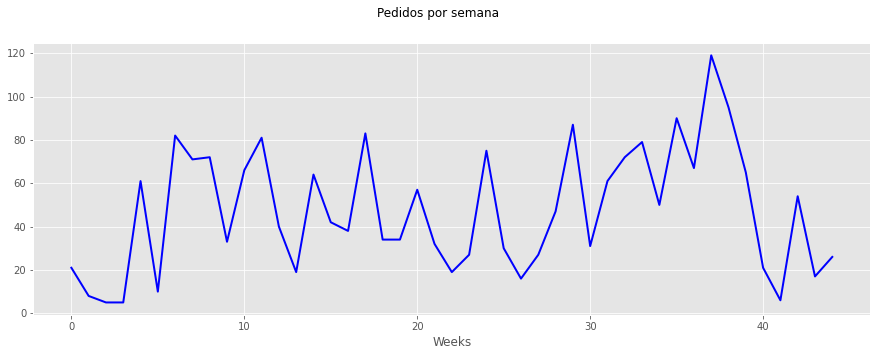

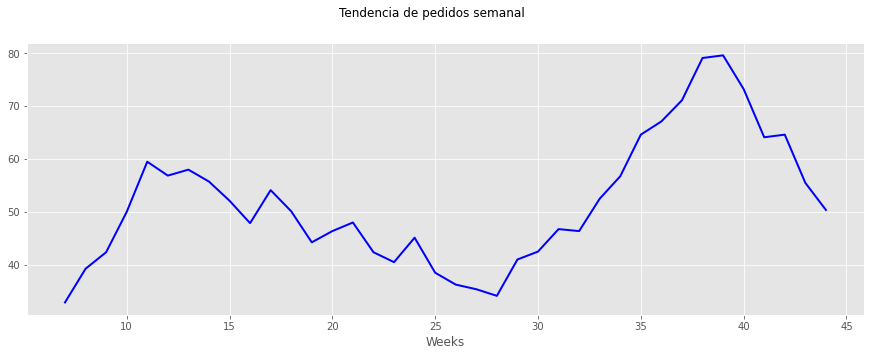

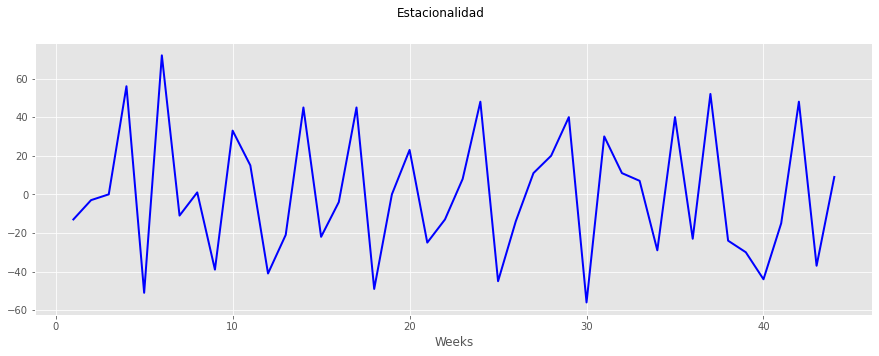

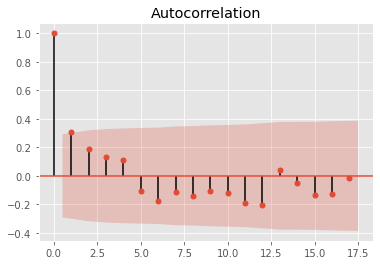

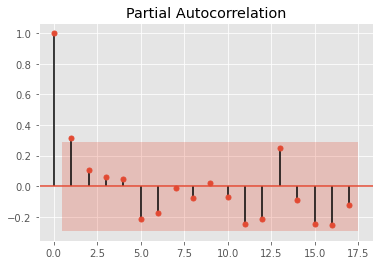

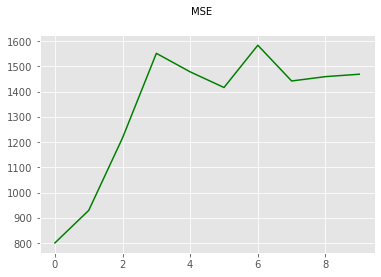

1


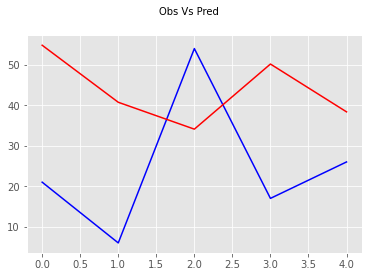

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Test MSE: 800.255
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   44
Model:                     ARMA(1, 0)   Log Likelihood                -207.537
Method:                       css-mle   S.D. of innovations             27.025
Date:                Tue, 13 Oct 2020   AIC                            421.074
Time:                        12:22:37   BIC                            426.427
Sample:                             0   HQIC                           423.059
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.4717      5.766      8.234      0.000      36.171      58.772
ar.L1.y        0.2986      0.146      2.051      0.040       0.013       0.584
                                  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Test MSE: 1286.000


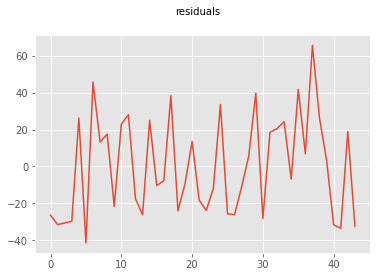

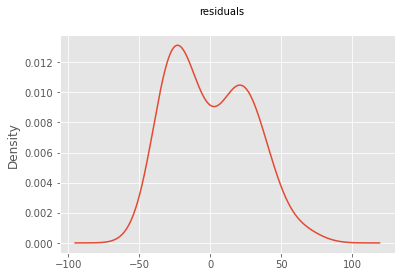

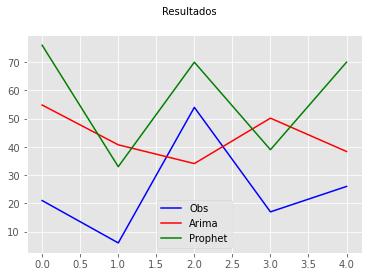

800.2551911557869 1286.0
PRODUCTO #:  Lechuga Crespa / Unidad
ADF Statistic: -4.775114
p-value: 0.000061
Critical Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


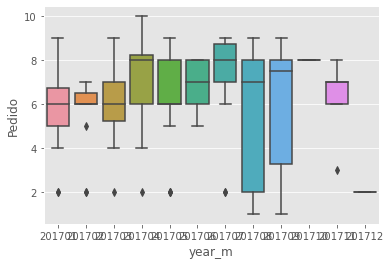

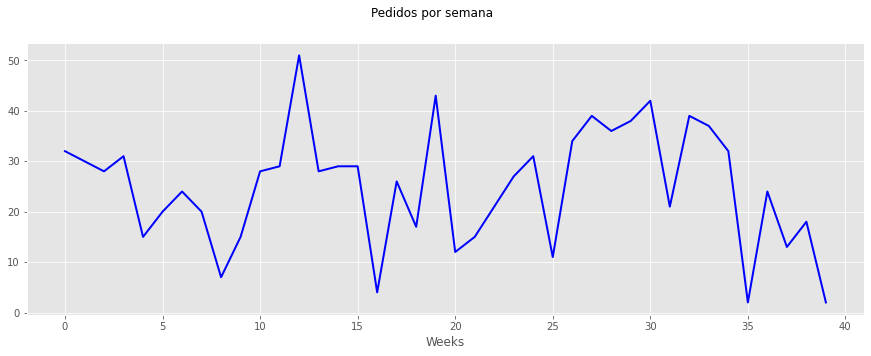

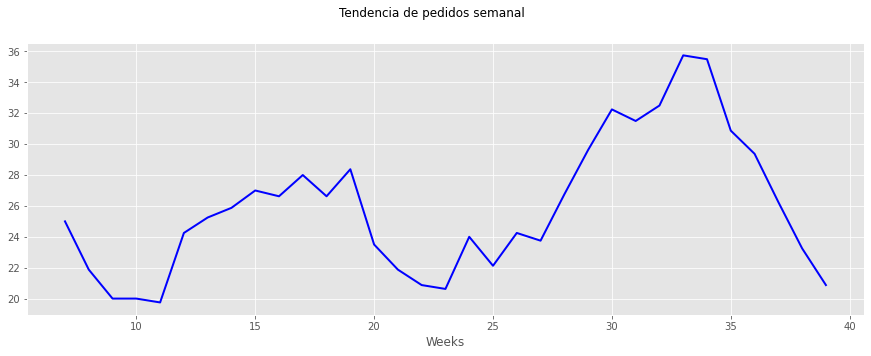

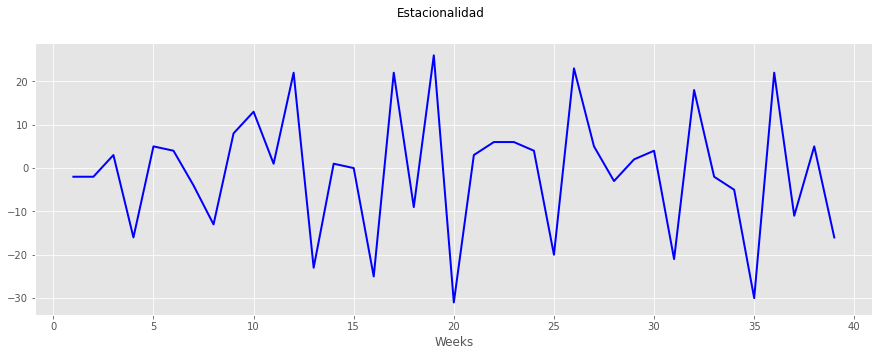

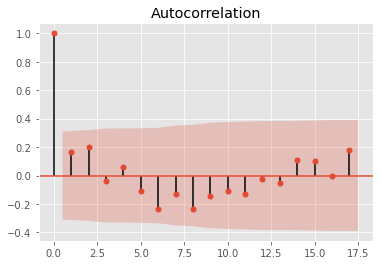

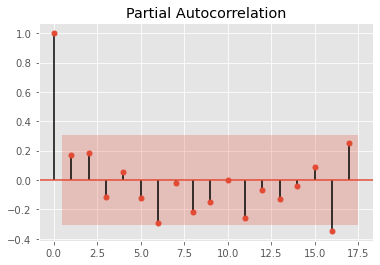

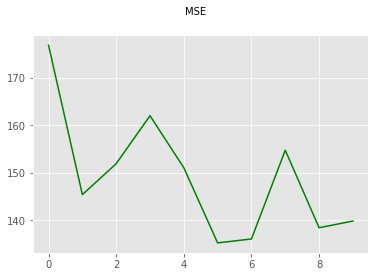

6


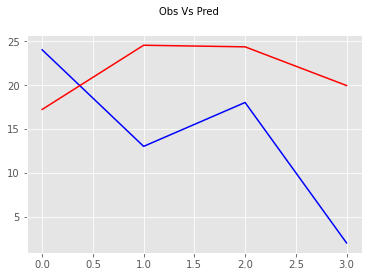

Test MSE: 135.163
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   39
Model:                     ARMA(6, 0)   Log Likelihood                -146.903
Method:                       css-mle   S.D. of innovations             10.401
Date:                Tue, 13 Oct 2020   AIC                            309.807
Time:                        12:23:31   BIC                            323.115
Sample:                             0   HQIC                           314.582
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7431      1.597     16.118      0.000      22.613      28.874
ar.L1.y        0.1280      0.154      0.832      0.406      -0.174       0.430
ar.L2.y        0.1547      0.155  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Test MSE: 120.250


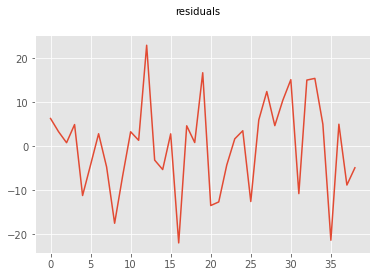

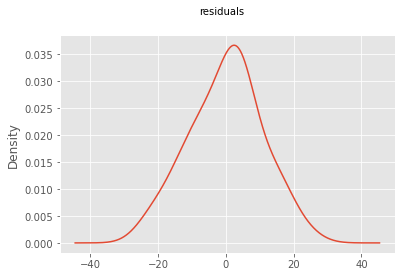

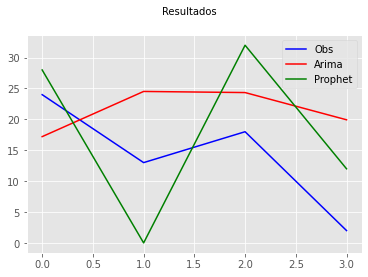

135.1626801390732 120.25
PRODUCTO #:  Zucchini Verde / Libra
ADF Statistic: -3.731317
p-value: 0.003694
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609


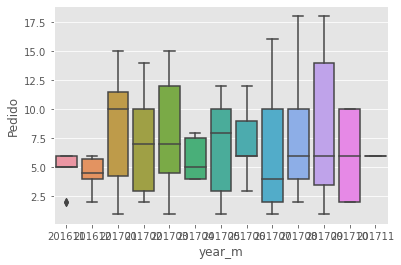

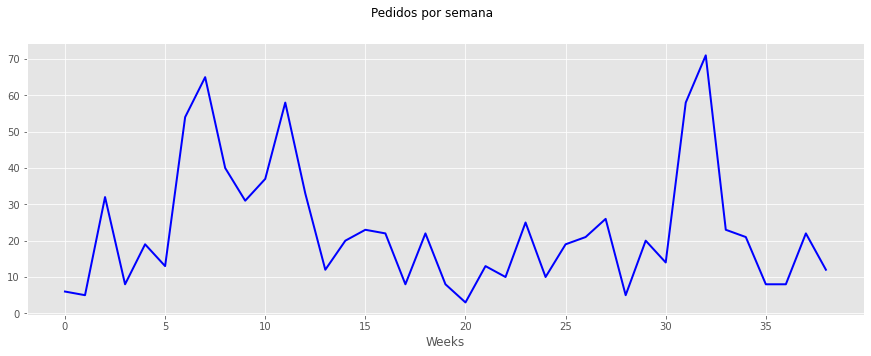

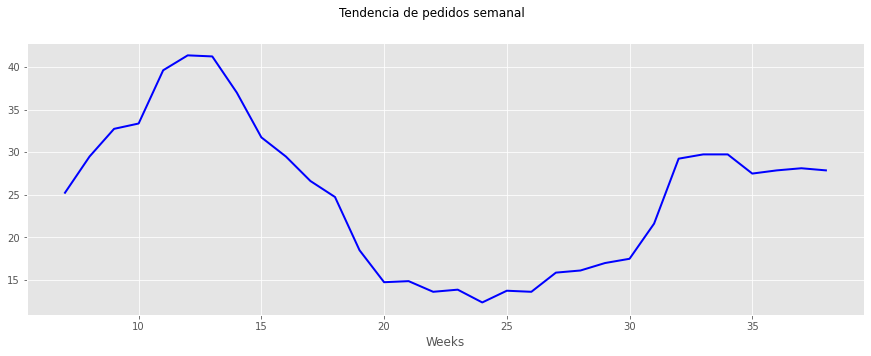

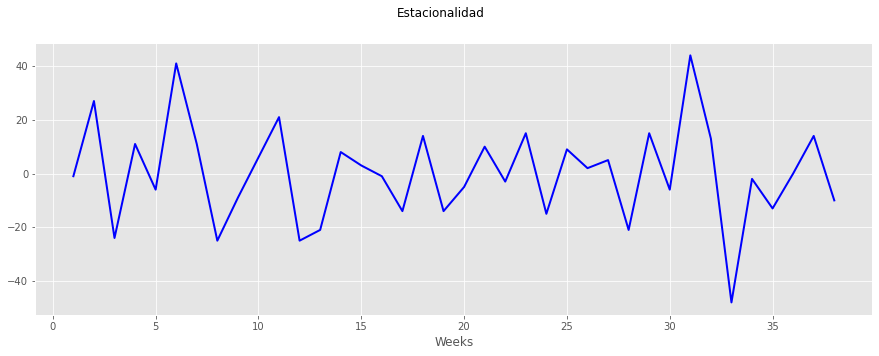

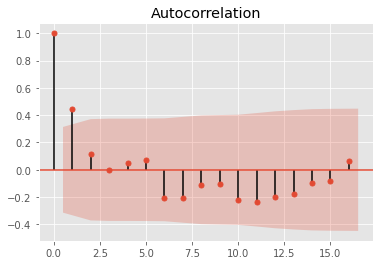

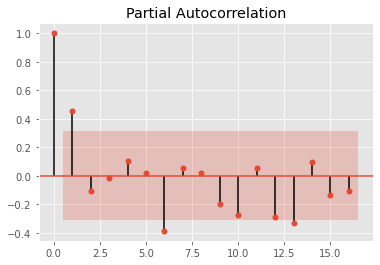

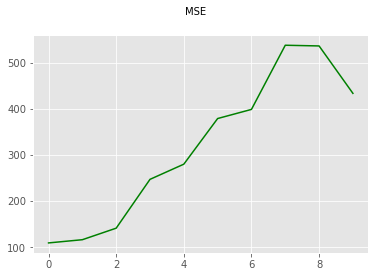

1


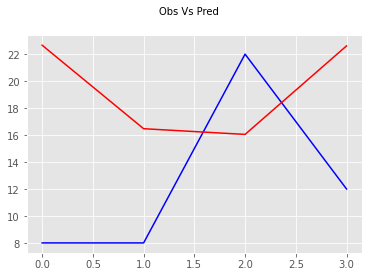

Test MSE: 108.664
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   38
Model:                     ARMA(1, 0)   Log Likelihood                -158.130
Method:                       css-mle   S.D. of innovations             15.478
Date:                Tue, 13 Oct 2020   AIC                            322.260
Time:                        12:24:50   BIC                            327.173
Sample:                             0   HQIC                           324.008
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.1091      4.469      5.172      0.000      14.351      31.867
ar.L1.y        0.4491      0.144      3.126      0.002       0.168       0.731
                                  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Test MSE: 197.500


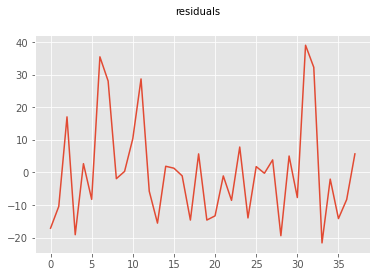

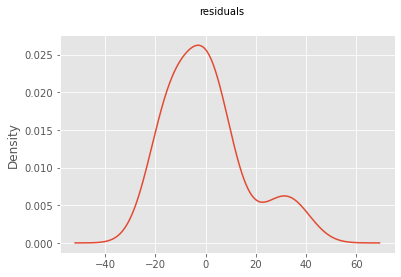

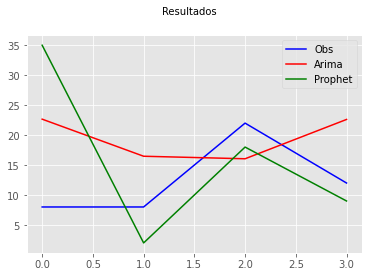

108.66406857416534 197.5
PRODUCTO #:  Pimentón Rojo / Libra
ADF Statistic: -4.479778
p-value: 0.000214
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


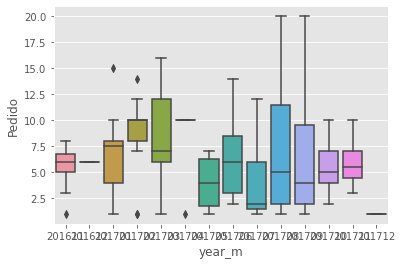

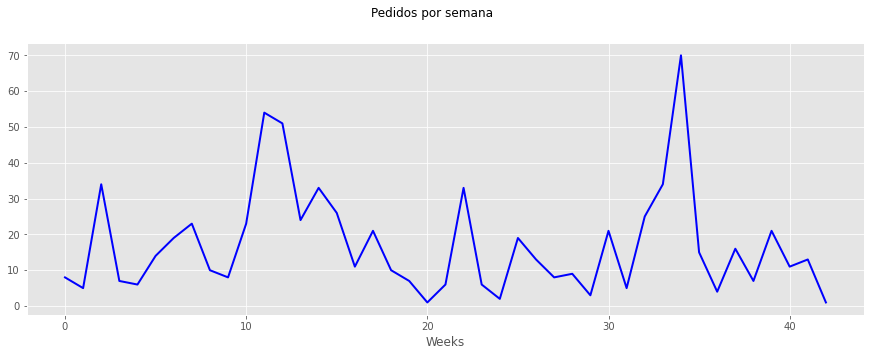

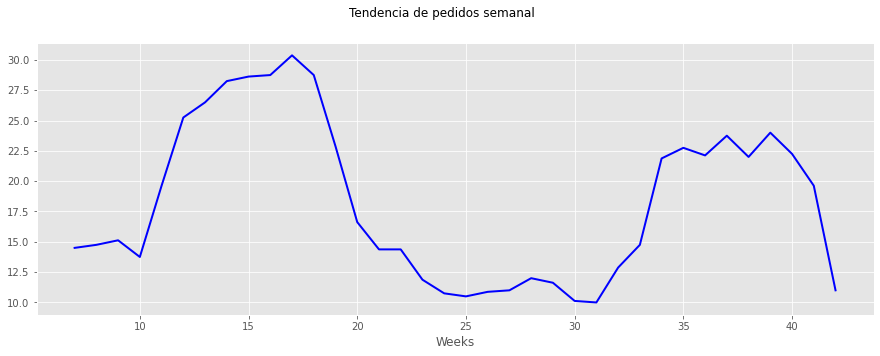

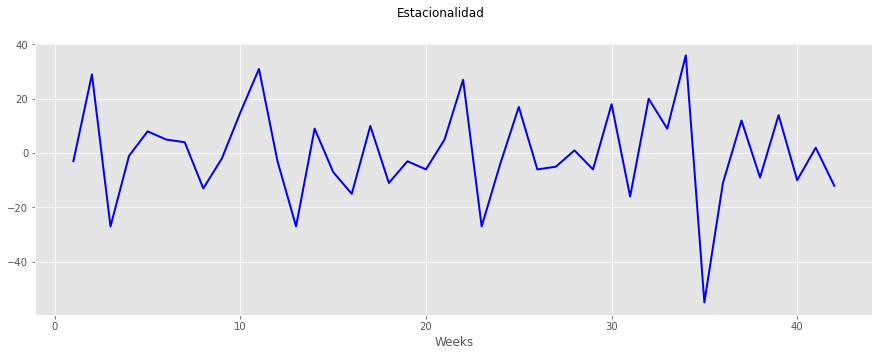

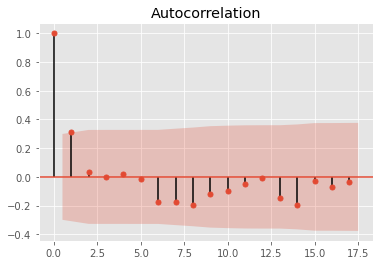

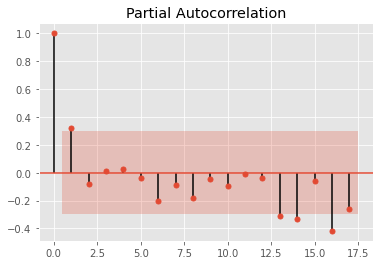

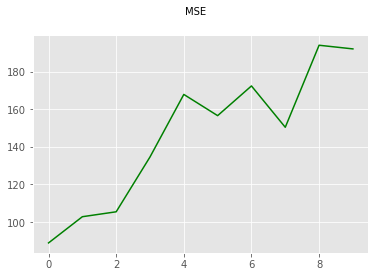

1


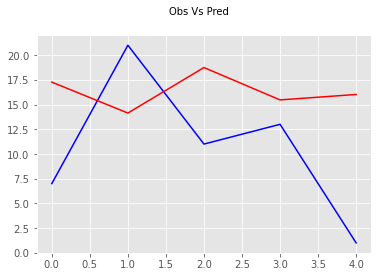

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Test MSE: 88.836
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   42
Model:                     ARMA(1, 0)   Log Likelihood                -170.282
Method:                       css-mle   S.D. of innovations             13.932
Date:                Tue, 13 Oct 2020   AIC                            346.565
Time:                        12:26:03   BIC                            351.778
Sample:                             0   HQIC                           348.476
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.3765      3.086      5.631      0.000      11.329      23.424
ar.L1.y        0.3103      0.145      2.136      0.033       0.026       0.595
                                   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seaso

Test MSE: 25.200


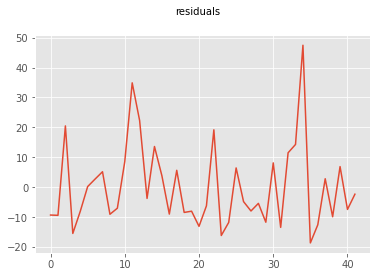

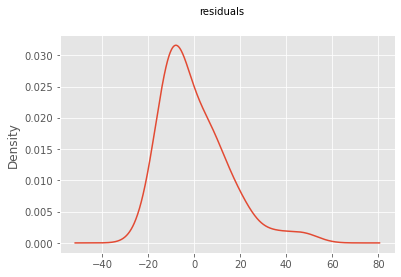

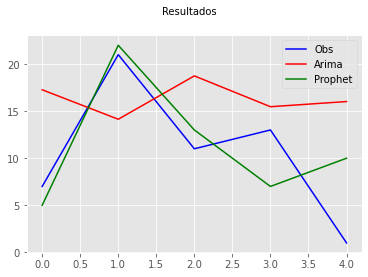

88.83572820953563 25.2
PRODUCTO #:  Pepino Cohombro / Libra
ADF Statistic: -2.627283
p-value: 0.087488
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609


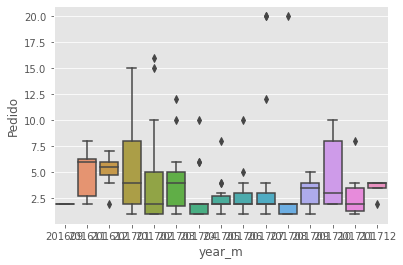

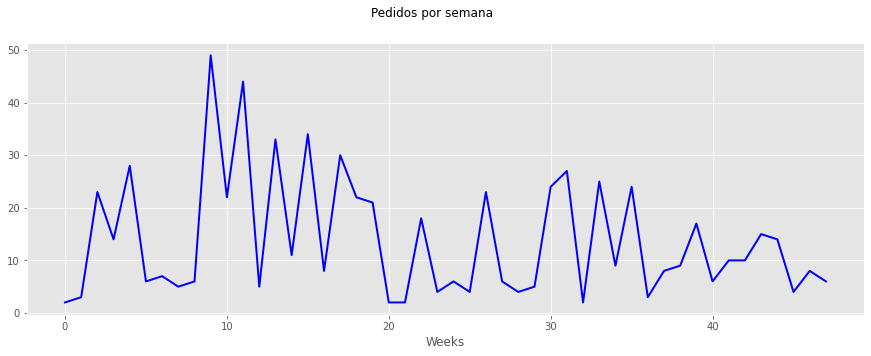

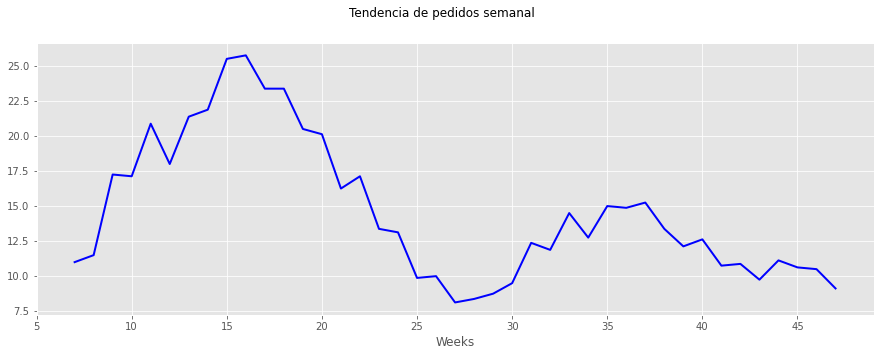

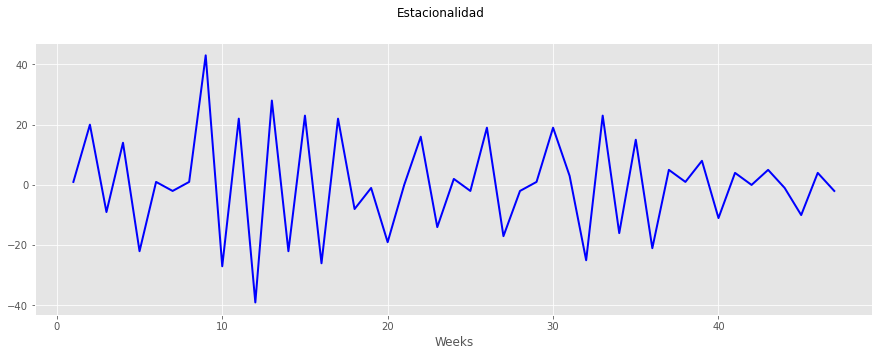

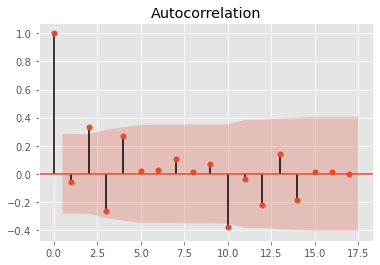

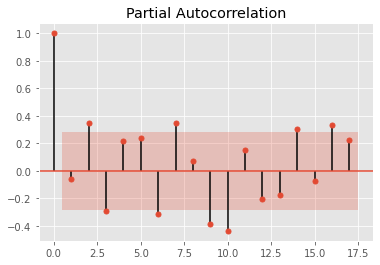

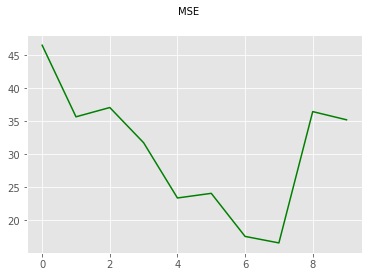

8


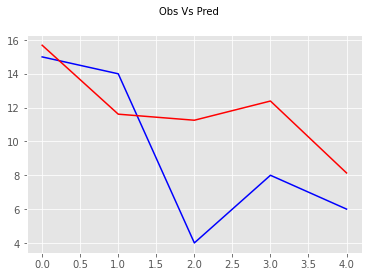

Test MSE: 16.530


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   47
Model:                     ARMA(8, 0)   Log Likelihood                -171.185
Method:                       css-mle   S.D. of innovations              9.048
Date:                Tue, 13 Oct 2020   AIC                            362.371
Time:                        12:27:27   BIC                            380.872
Sample:                             0   HQIC                           369.333
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2736      2.719      4.882      0.000       7.945      18.602
ar.L1.y        0.2125      0.149      1.425      0.154      -0.080       0.505
ar.L2.y        0.3261      0.143      2.281      0.0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Test MSE: 28.600


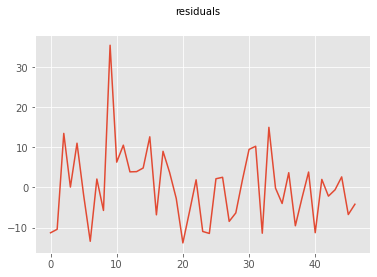

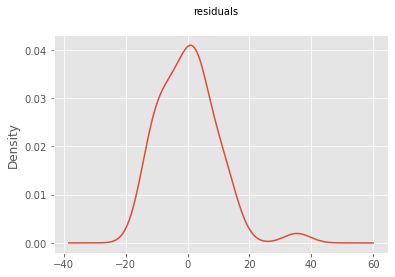

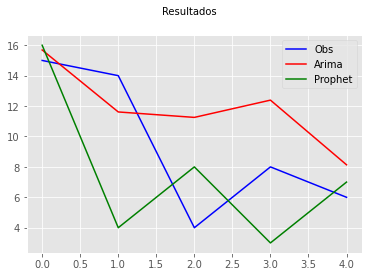

16.530454857814092 28.6
PRODUCTO #:  Berenjena / Libra
ADF Statistic: -5.586204
p-value: 0.000001
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609


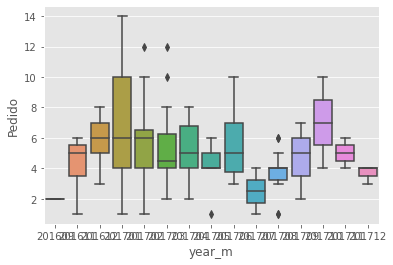

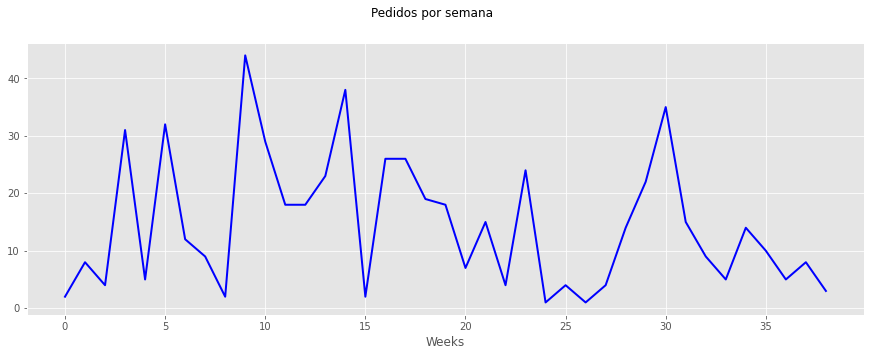

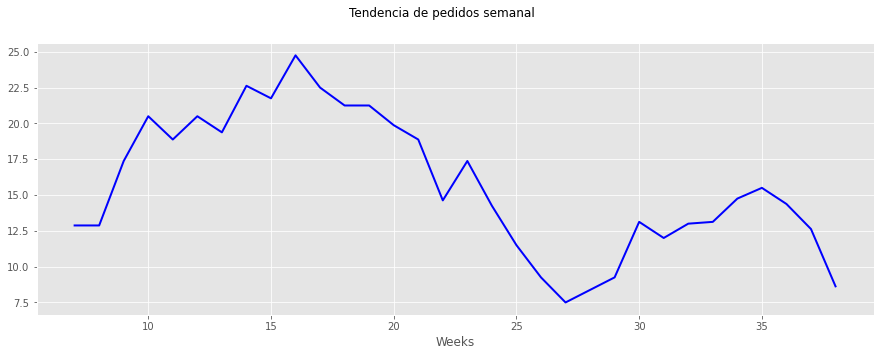

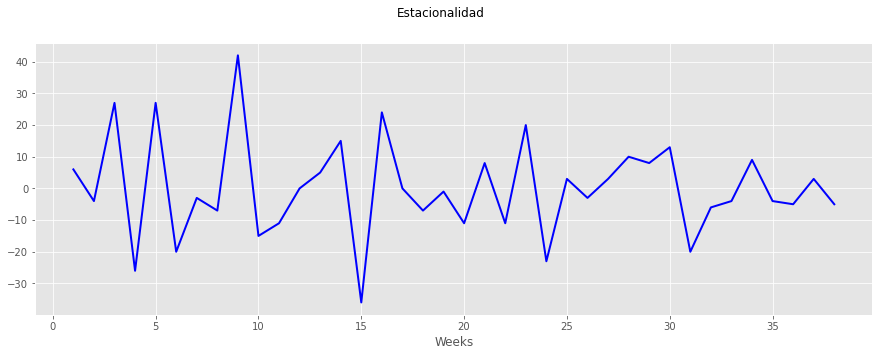

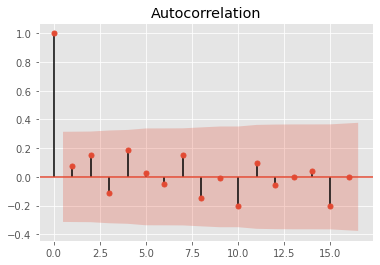

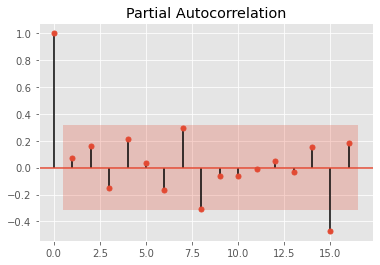

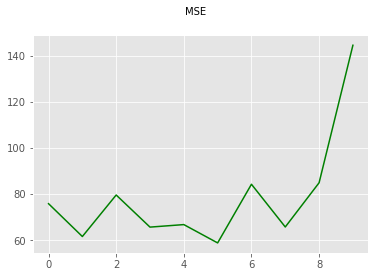

6


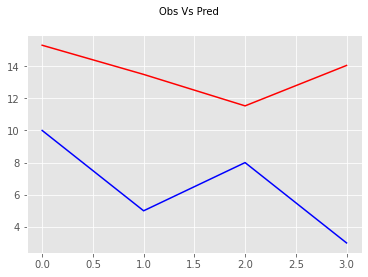

Test MSE: 58.676
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   38
Model:                     ARMA(6, 0)   Log Likelihood                -144.563
Method:                       css-mle   S.D. of innovations             10.813
Date:                Tue, 13 Oct 2020   AIC                            305.125
Time:                        12:28:24   BIC                            318.226
Sample:                             0   HQIC                           309.786
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.7998      2.123      6.970      0.000      10.638      18.961
ar.L1.y        0.0957      0.159      0.603      0.547      -0.216       0.407
ar.L2.y        0.1366      0.161   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Test MSE: 31.000


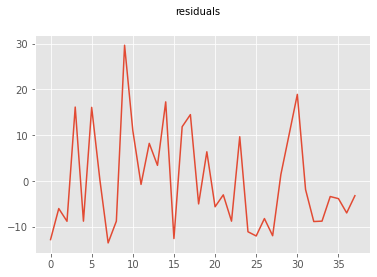

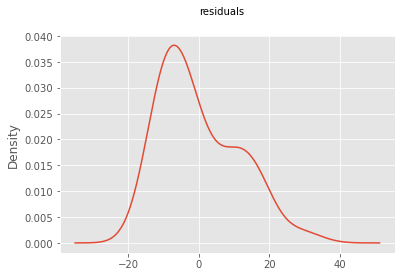

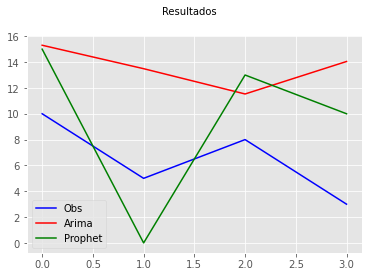

58.676388788305644 31.0
PRODUCTO #:  Cebolla Cabezona Roja / Libra
ADF Statistic: -2.735320
p-value: 0.068123
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623


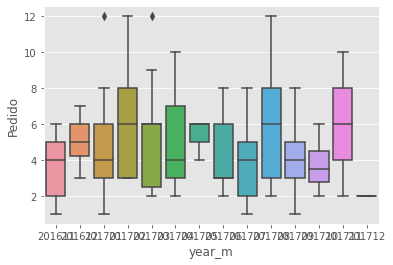

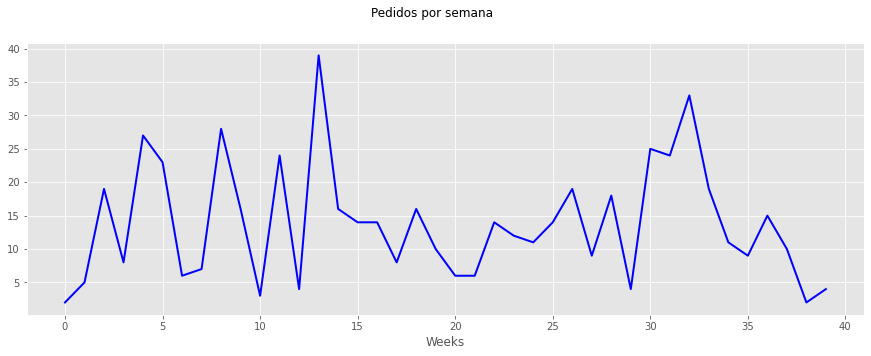

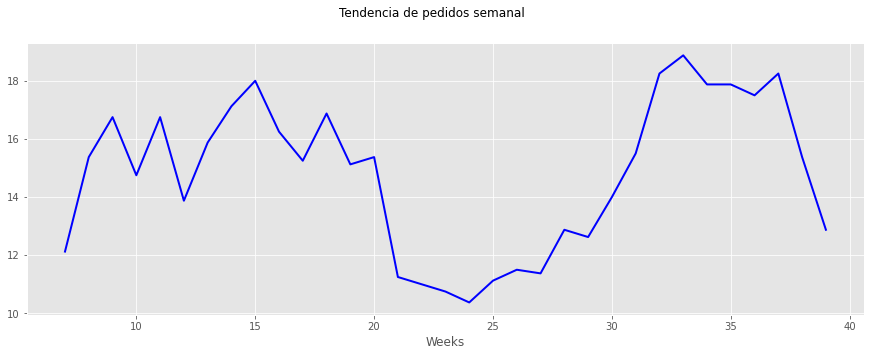

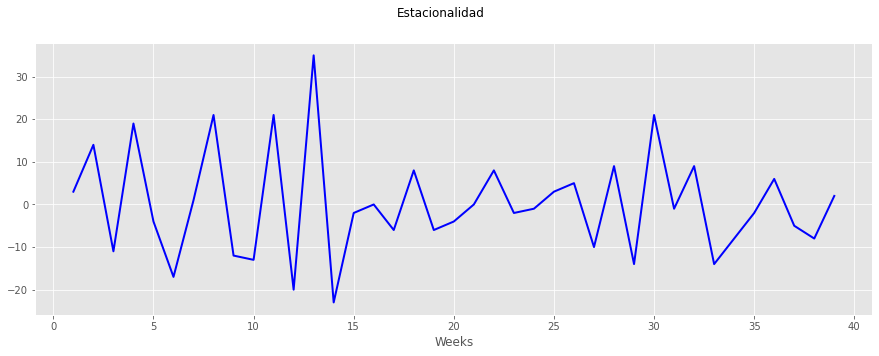

G:\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



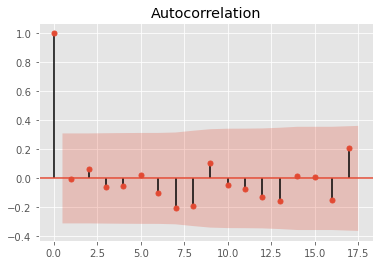

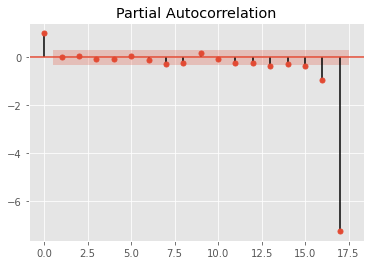

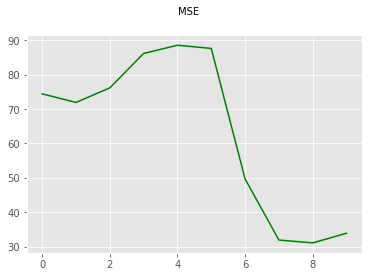

9


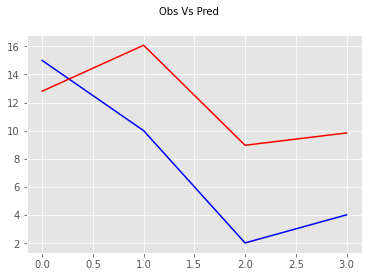

Test MSE: 31.066


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   39
Model:                     ARMA(9, 0)   Log Likelihood                -136.681
Method:                       css-mle   S.D. of innovations              7.873
Date:                Tue, 13 Oct 2020   AIC                            295.361
Time:                        12:29:27   BIC                            313.661
Sample:                             0   HQIC                           301.927
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.3708      0.893     16.101      0.000      12.621      16.120
ar.L1.y       -0.0884      0.160     -0.553      0.580      -0.401       0.225
ar.L2.y        0.0892      0.160      0.556      0.5

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Test MSE: 32.750


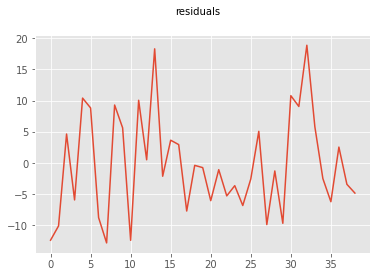

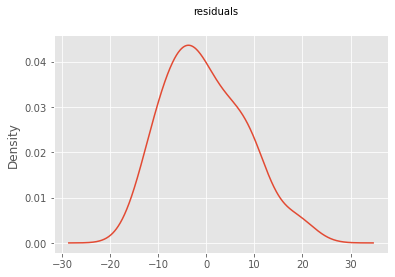

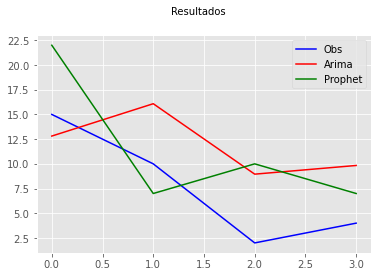

31.066011445051554 32.75
PRODUCTO #:  Limón Tahití / Libra
ADF Statistic: -6.794640
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


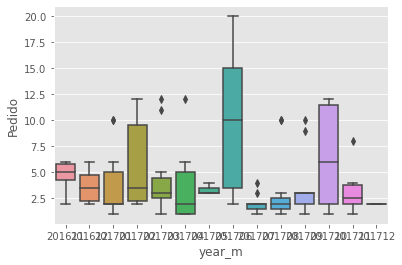

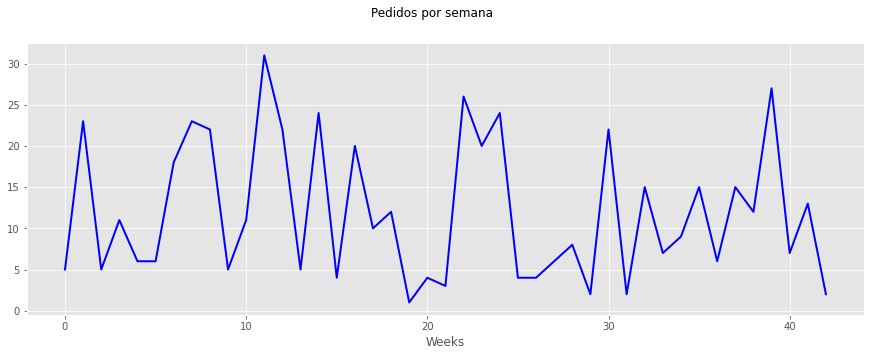

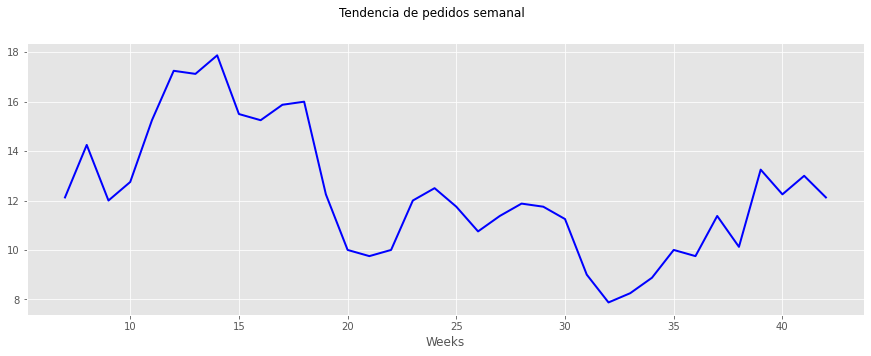

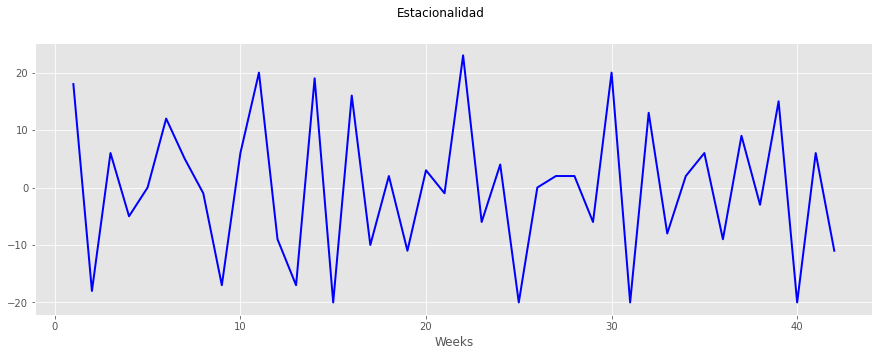

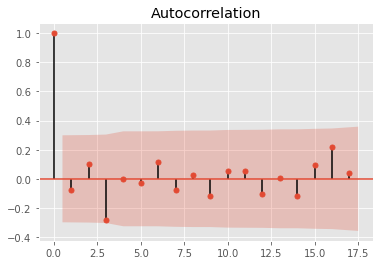

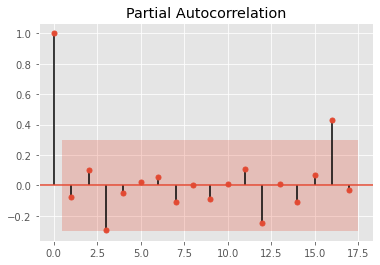

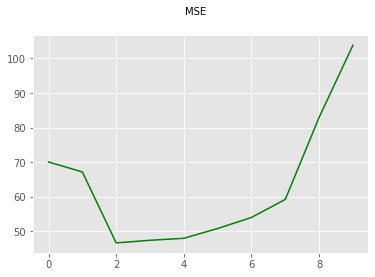

3


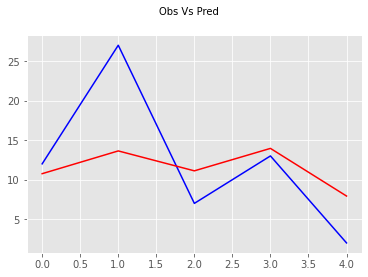

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Test MSE: 46.630
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   42
Model:                     ARMA(3, 0)   Log Likelihood                -146.772
Method:                       css-mle   S.D. of innovations              7.947
Date:                Tue, 13 Oct 2020   AIC                            303.543
Time:                        12:30:23   BIC                            312.232
Sample:                             0   HQIC                           306.728
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.2340      1.014     12.062      0.000      10.246      14.222
ar.L1.y       -0.0537      0.148     -0.364      0.716      -0.343       0.235
ar.L2.y        0.0866      0.149   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Test MSE: 162.200


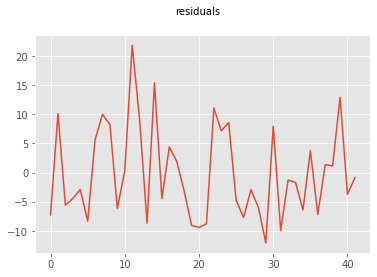

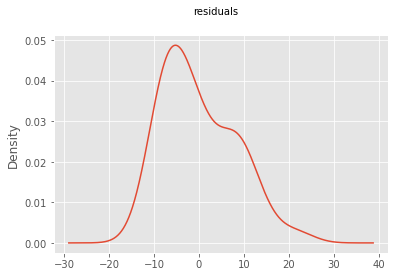

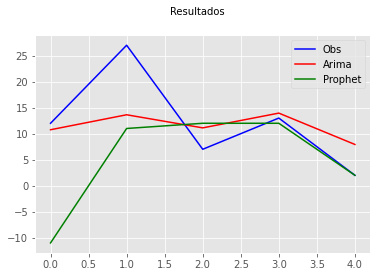

46.6296449949319 162.2
PRODUCTO #:  Champiñón / Libra
ADF Statistic: -4.707536
p-value: 0.000081
Critical Values:
	1%: -3.589
	5%: -2.930
	10%: -2.603


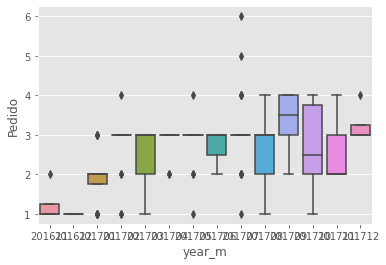

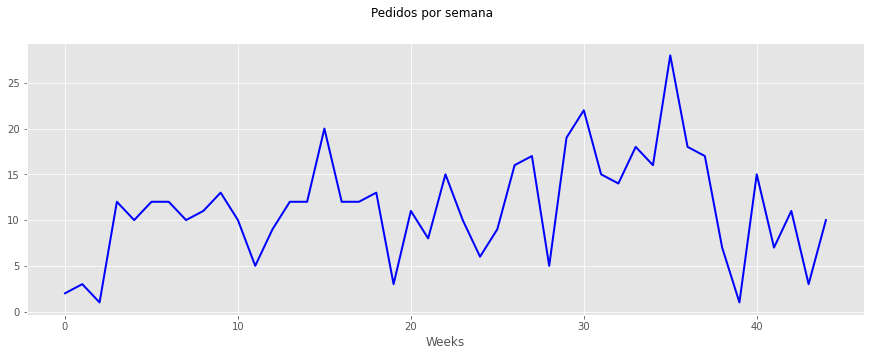

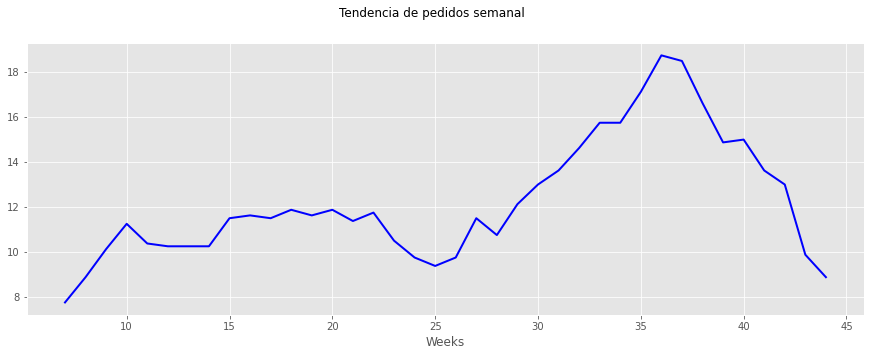

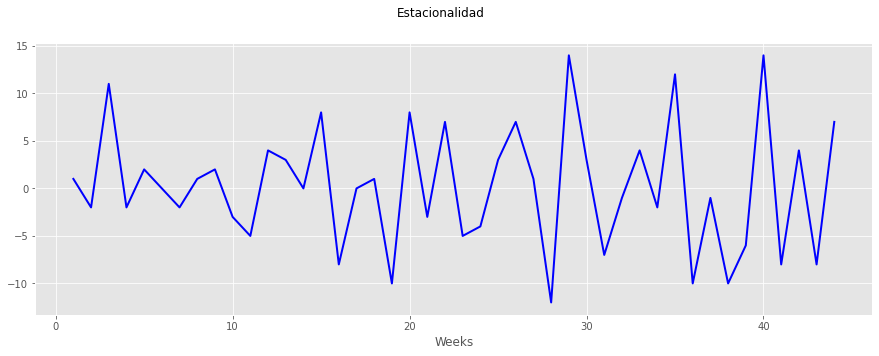

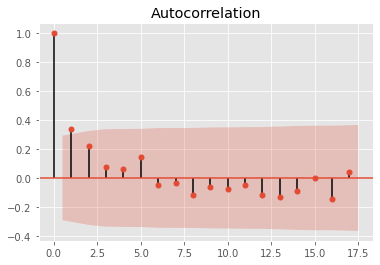

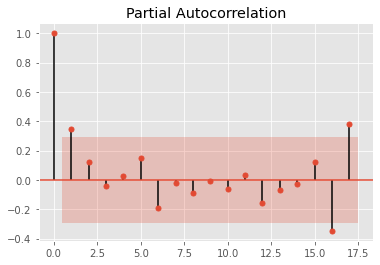

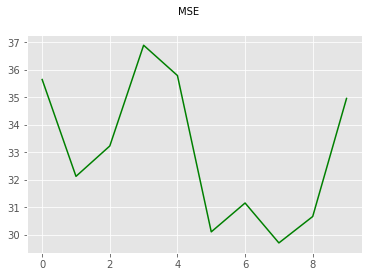

8


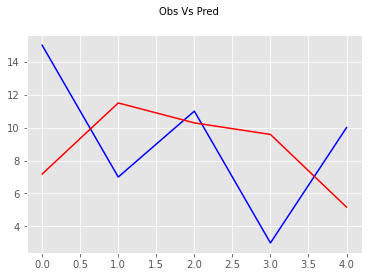

Test MSE: 29.704


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   44
Model:                     ARMA(8, 0)   Log Likelihood                -134.628
Method:                       css-mle   S.D. of innovations              5.113
Date:                Tue, 13 Oct 2020   AIC                            289.257
Time:                        12:31:26   BIC                            307.099
Sample:                             0   HQIC                           295.873
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1160      1.451      7.662      0.000       8.273      13.959
ar.L1.y        0.3593      0.152      2.364      0.018       0.061       0.657
ar.L2.y        0.1003      0.162      0.619      0.5

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Test MSE: 16.800


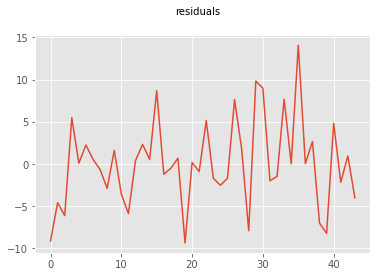

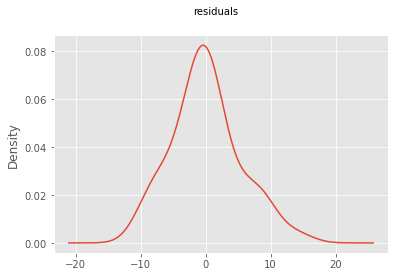

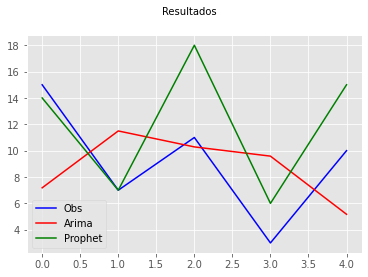

29.703651990215043 16.8


In [68]:
for i in range(0, len(productos4)):
    print('PRODUCTO #: ', productos4.index[i])
    new_data = datos(data_n[(data_n.Nombre_producto == productos4.index[i])])
    ar_num, mse_ar, mse_p = proceso(data_n[(data_n.Nombre_producto == productos4.index[i])], new_data)
    ar_num_proceso.append(ar_num)
    mse_ar_proceso.append(mse_ar)
    mse_pro_proceso.append(mse_p)

In [69]:
ar_num_proceso

[1, 6, 1, 1, 8, 6, 9, 3, 8]

In [70]:
mse_ar_proceso

[800.2551911557869,
 135.1626801390732,
 108.66406857416534,
 88.83572820953563,
 16.530454857814092,
 58.676388788305644,
 31.066011445051554,
 46.6296449949319,
 29.703651990215043]

In [71]:
mse_pro_proceso

[1286.0, 120.25, 197.5, 25.2, 28.6, 31.0, 32.75, 162.2, 16.8]

#### Graficamos el **MSE** de cada modelo (**ARIMA** y **Prophet**) en los **9** productos: 

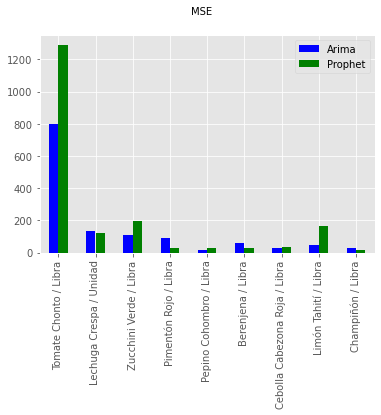

In [72]:
mse_ar_proceso_df = pd.DataFrame(mse_ar_proceso)
mse_pro_proceso_df = pd.DataFrame(mse_pro_proceso)
mse_ar_proceso_df = mse_ar_proceso_df.rename(columns={0: 'Arima'})
mse_pro_proceso_df = mse_pro_proceso_df.rename(columns={0: 'Prophet'})
grafica_mse = pd.concat([mse_ar_proceso_df, mse_pro_proceso_df], axis=1)
for i in range(0, len(productos4)):
    grafica_mse = grafica_mse.rename(index={i: productos4.index[i]})
grafica_mse[['Arima', 'Prophet']].plot(color=('b', 'g'), kind="bar")
plt.suptitle('MSE', fontsize=10)
plt.xticks(rotation='vertical');

#### Se observa que para **Tomate chonto** en modelo **Arima** tiene mejor desempeño, para los productos restantes las diferencias no son tan marcadas, con **Prophet** se logra menor **MSE** en 4 productos.

#### Es importante resaltar que ambos algoritmos tienen predicciones similares al analizar los resultados por producto. 

### Estimación de demanda para un periodo nuevo:

#### Por último, predecimos la demanda por producto y graficamos los valores predichos con la serie histórica de datos, utilizando Arima y Prophet:

In [73]:
predictions_ari = []
predictions_pro = []

for i in range(0, len(productos4)):
    new_data = datos(data_n[(data_n.Nombre_producto == productos4.index[i])])
    
    predi_ari2 = arima2(new_data, ar_num_proceso[i])
    predictions_ari.append(predi_ari2)
    
    df_n = datos_prophet(new_data)
    predi_pro2 = prophet2(df_n)
    predictions_pro.append(predi_pro2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [74]:
predictions_ari

[[array([40.53900761])],
 [array([21.32648168])],
 [array([17.83633457])],
 [array([11.82487964])],
 [array([14.92034688])],
 [array([13.91397534])],
 [array([9.28152667])],
 [array([14.20999592])],
 [array([11.81793723])]]

In [75]:
predictions_pro

[[65], [7], [10], [8], [6], [7], [5], [2], [14]]

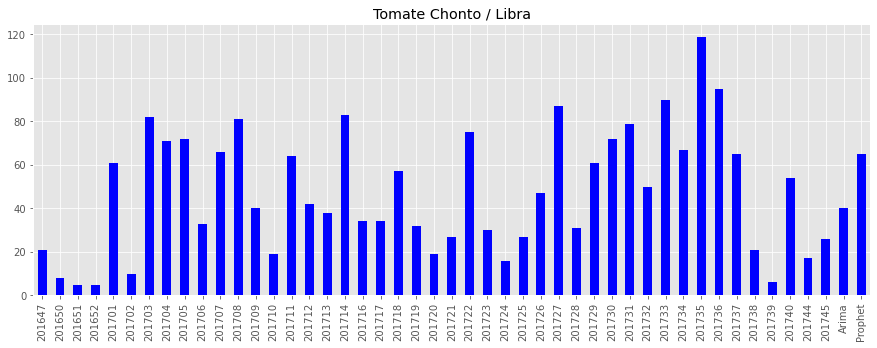

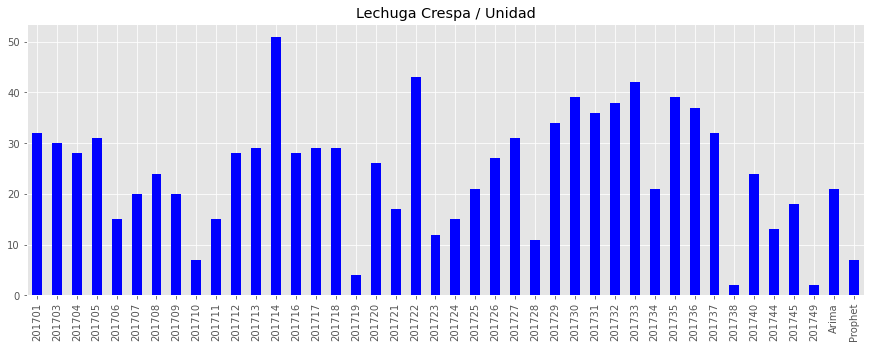

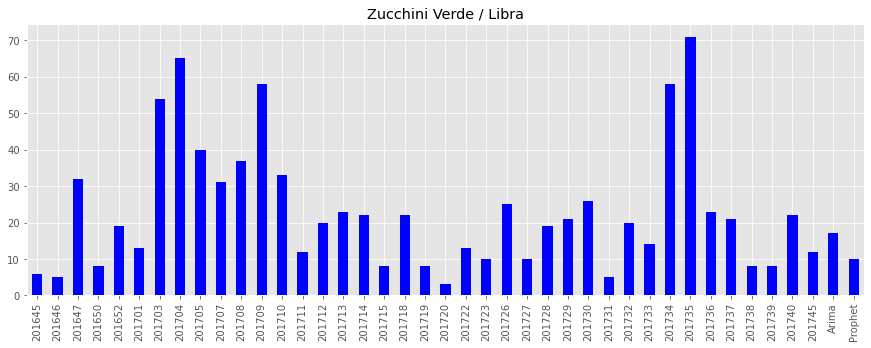

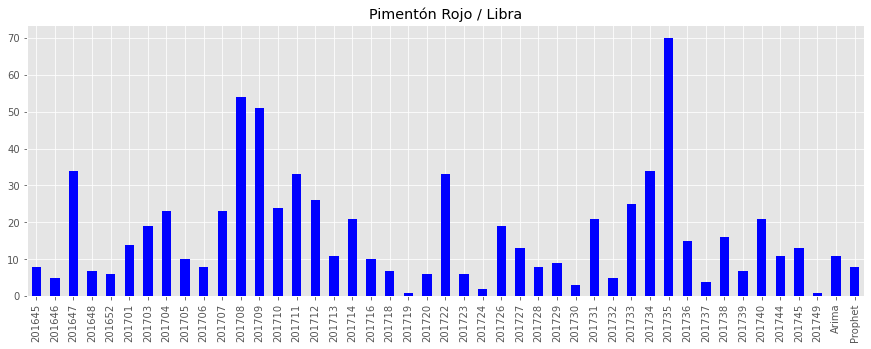

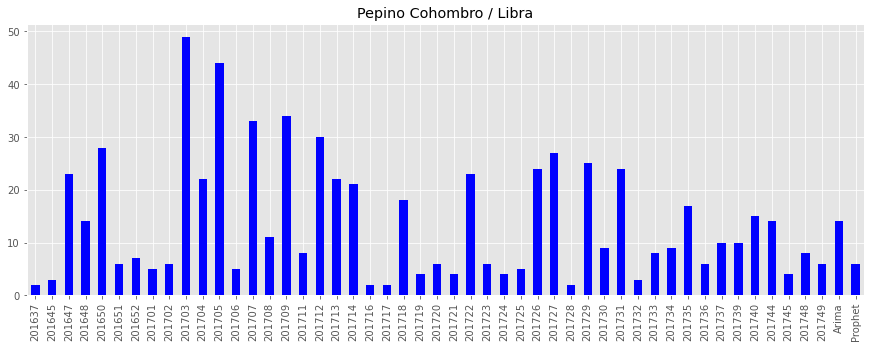

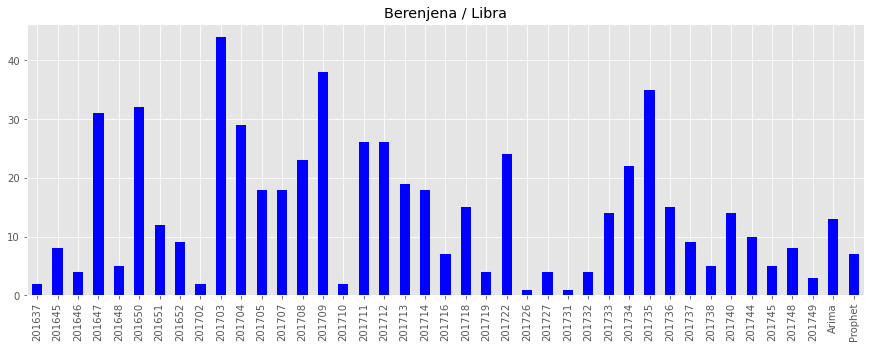

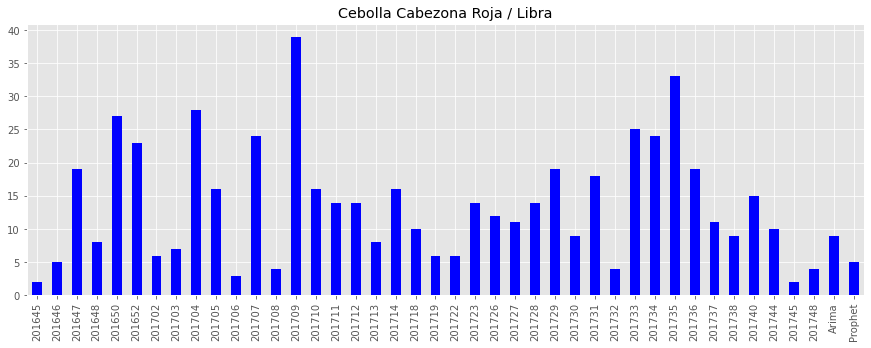

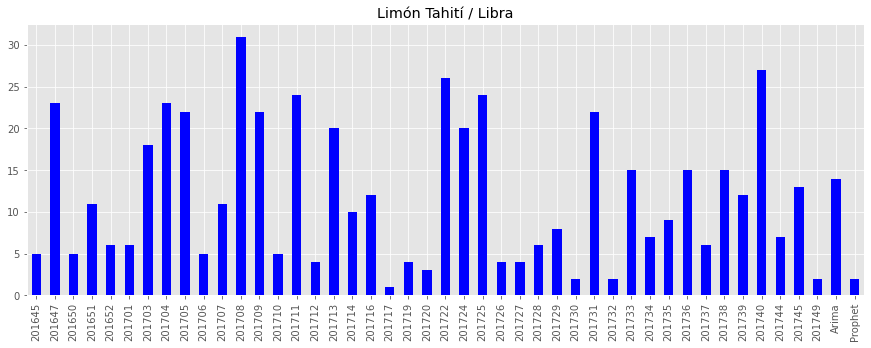

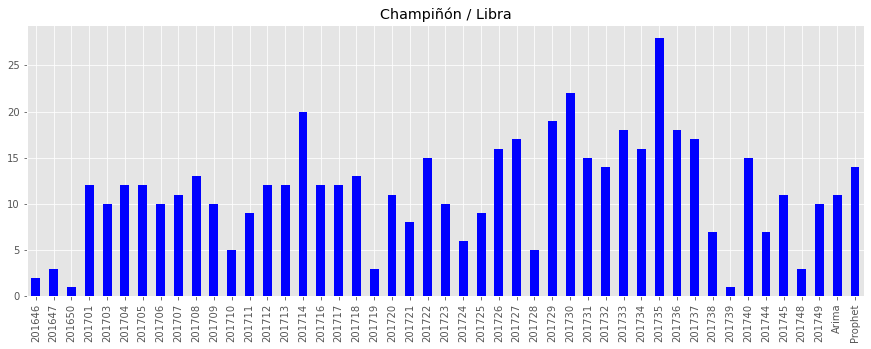

In [76]:
for i in range(0, len(productos4)):
    grafica_final(i)

#### * Los dos últimos valores en la gráfica, corresponden a predicciones con Arima y Prophet en el **mismo** periodo. (Se grafican consecutivas únicamente para apreciar visualmente la tendencia y/o diferencia)

#### Como se aprecia, los dos algoritmos tienen predicciones similares, para la mayoría de los casos la predicción de Prophet se encuentra por debajo que la predicción usando Arima. 

#### En todo caso no se da preferencia a ningún algoritmo en especial, se recomienda a la compañía agrícola el uso de los dos para estimar 12 periodos siguientes, que equivalen a 3 meses aproximadamente y nuevamente evaluar su desempeño.

#### Posteriormente a una posible o no preferencia entre los algoritmos, se recomienda la inclusión de nuevos productos de acuerdo con priorización en mayor participación. 